In [20]:
from SVDModel import SVDModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import pickle
import os.path
from pathlib import Path

np.random.seed(3362)

In [2]:
# Parameters
PARAM = dict()
PARAM['path'] = {
  'ml':'./data/MovieLens25M/',
  'netflix':'./data/NetflixPrize/'
}

PARAM

{'path': {'ml': './data/MovieLens25M/', 'netflix': './data/NetflixPrize/'}}

In [3]:
ML_25M = {}
hasReindex = True
try:
  ML_25M['ratings'] = pd.read_csv(PARAM['path']['ml']+'ratings_newMovieId_no_index.csv')
except:
  hasReindex = False
  ML_25M['ratings'] = pd.read_csv(PARAM['path']['ml']+'ratings.csv')

ML_25M['movies'] = pd.read_csv(PARAM['path']['ml']+'movies.csv')

ML_25M['movies'].insert(1, 'newMovieId', value=range(1,len(ML_25M['movies'])+1))
newMovieIdDict = {}
for index, movie in ML_25M['movies'].iterrows():
    newMovieIdDict[movie['movieId']] = movie['newMovieId']

if not hasReindex:
  ML_25M['ratings_reindex'] = ML_25M['ratings']

  for index, rating in ML_25M['ratings'].iterrows():
    if index % 1000000 == 0: print('{}/{}'.format(index, len(ML_25M['ratings'])))
    ML_25M['ratings_reindex'].at[index, 'movieId'] = newMovieIdDict[rating['movieId']]

  ML_25M['ratings_reindex'].to_csv(PARAM['path']['ml']+'ratings_newMovieId_no_index.csv', index = False)

  ML_25M['ratings'] = ML_25M['ratings_reindex']

ML_25M['movies'].drop(columns=['movieId'], inplace=True)
ML_25M['movies'].rename(columns={"newMovieId": "movieId"}, inplace=True)

ML_25M['ratings'] = ML_25M['ratings'].sort_values(by=['userId'])
ML_25M['movies'] = ML_25M['movies'].sort_values(by=['movieId'])

In [4]:
maxNumberOfUser = 50000
maxNumberOfMovie = 20000

maxNumberOfReview = ML_25M['ratings'][ML_25M['ratings']['userId'] == maxNumberOfUser].index[-1]
ML_25M['ratings'] = ML_25M['ratings'][:maxNumberOfReview]

ML_25M['movies'] = ML_25M['movies'][:maxNumberOfMovie]

# inner join by movieId
ML_25M['ratings'] = ML_25M['ratings'].merge(ML_25M['movies'], on='movieId')[['userId', 'movieId', 'rating']]
ML_25M['ratings']

ML_25M['m_movies'] = ML_25M['movies']['movieId'].nunique()
ML_25M['n_users'] = ML_25M['ratings']['userId'].nunique()
ML_25M['n_ratings'] = len(ML_25M['ratings'])

ML_25M['ratings']['userId'] = ML_25M['ratings']['userId'].astype(np.int32)
ML_25M['ratings']['movieId'] = ML_25M['ratings']['movieId'].astype(np.int32)
ML_25M['ratings']['rating'] = ML_25M['ratings']['rating'].astype(np.float32)

ML_25M

{'ratings':          userId  movieId  rating
 0             1      293     5.0
 1             3      293     5.0
 2             4      293     4.0
 3             5      293     4.0
 4             7      293     4.0
 ...         ...      ...     ...
 7213863   49403     5033     0.5
 7213864   49631    19610     4.0
 7213865   49879    19188     0.5
 7213866   49901    19862     1.0
 7213867   49901    17840     1.0
 
 [7213868 rows x 3 columns],
 'movies':        movieId                                        title  \
 0            1                             Toy Story (1995)   
 1            2                               Jumanji (1995)   
 2            3                      Grumpier Old Men (1995)   
 3            4                     Waiting to Exhale (1995)   
 4            5           Father of the Bride Part II (1995)   
 ...        ...                                          ...   
 19995    19996                                 Joker (2012)   
 19996    19997             

In [5]:
print(ML_25M['ratings'].shape)
print(ML_25M['movies'].shape)

(7213868, 3)
(20000, 3)


In [6]:
data = 'ML_25M'

print('Creating SVD Model')
svd = SVDModel()
print("Created\nLoading Data")
if data=='ML_25M':
    svd.data_loader(data=ML_25M['ratings'], 
                    n_items = ML_25M['m_movies'], 
                    n_users= ML_25M['n_users'])
else:
    svd.data_loader(data=NETFLIX['ratings'], 
                    n_items = NETFLIX['m_movies'], 
                    n_users= NETFLIX['n_users'])

print("Loaded Data\nSpliting Data")
svd.split(0.8,0.8)
print("Splitted Data\nTraining...")

Creating SVD Model
Created
Loading Data
Loaded Data
Spliting Data
User Item Matrix Shape: userItemMatrix.shape
User Reference length: self.n_users
Item Reference length: self.n_items
Splitted Data
Training...


In [7]:
PARAM['features'] = [3, 30, 150, 300]
PARAM['lr'] = [1e-2, 1e-3, 1e-4]
PARAM['epochs'] = [11, 101, 201, 301, 501]
PARAM['weight_decay'] = [0.02, 0.2, 2]
PARAM['stopping'] = 0.001

if data=='ML_25M':
    resultDir = 'model_movielens'
else:
    resultDir = 'model_netflix'

def train_model(features, lr, epochs, data, weight_decay):
    if os.path.isfile(f'./{resultDir}/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
        return
    
    svd.features = features
    svd.lr = lr
    svd.epochs = epochs
    svd.data = data
    svd.weight_decay = weight_decay
    svd.stopping = PARAM['stopping']

    print(f"==============================")
    print(f'features: {svd.features}\nlearning rate: {svd.lr}\nEpochs: {svd.epochs}\nweight decay: {svd.weight_decay}\nstopping: {svd.stopping}\n')

    
    start = time.perf_counter()
    result = svd.training()
    print('Time used =', time.perf_counter()-start)
    
    print('Saving Model')
    svd.data = []
    Path(f"./{resultDir}").mkdir(parents=True, exist_ok=True)
    Path(f"./{resultDir}/funk").mkdir(parents=True, exist_ok=True)
    Path(f"./{resultDir}/funk/model").mkdir(parents=True, exist_ok=True)
    Path(f"./{resultDir}/funk/result").mkdir(parents=True, exist_ok=True)
    
    
    # with open(f'./{resultDir}/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
    #     pickle.dump(svd, out, pickle.HIGHEST_PROTOCOL)
    #     out.close()
    with open(f'./{resultDir}/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
        pickle.dump(result, out, pickle.HIGHEST_PROTOCOL)
        out.close()
    print(f"==============================")
    return svd, result

In [8]:
totalNumOfExperienment = len(PARAM['features']) * len(PARAM['lr']) * len(PARAM['epochs']) * len(PARAM['weight_decay'])
i=1
for epochs in PARAM['epochs']:
    for features in PARAM['features']:
        for lr in PARAM['lr']:
            for weight_decay in PARAM['weight_decay']:
                for data in ['ML_25M']:
                    print(f"NumOfExperienment: {i}/{totalNumOfExperienment}")
                    train_model(features, lr, epochs, data, weight_decay)
                    i+=1

NumOfExperienment: 1/180
features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001

Epoch :    1  | Train : nan  | Valid : nan  | Time : 10.30824s
Epoch :   11  | Train : nan  | Valid : nan  | Time : 20.03334s
Training stopped:
Epoch :   11  | Train Loss : nan  | Valid Loss: nan  | Test Loss: nan
Time used = 30.597291700000014
Saving Model
NumOfExperienment: 2/180
features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001

Epoch :    1  | Train : 1.871  | Valid : 1.894  | Time : 3.15205s
Training stopped:
Epoch :    7  | Train Loss : 0.810  | Valid Loss: 0.837  | Test Loss: 0.837
Time used = 25.6987235
Saving Model
NumOfExperienment: 3/180
features: 3
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001

Epoch :    1  | Train : 7.586  | Valid : 7.609  | Time : 11.61476s
Epoch :   11  | Train : 4.808  | Valid : 4.825  | Time : 19.41267s
Training stopped:
Epoch :   11  | Train Loss : 4.808  | Valid Loss: 4.825  | Test Loss: 4.819
Time used 

# Graph
$$MSE=\frac{1}{N}\sum_{i=1}^N(predict_i-actual_i)^2$$
$$RMSE=\sqrt{\frac{\sum_{i=1}^N(predict_i-actual_i)^2}{N}}$$

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001



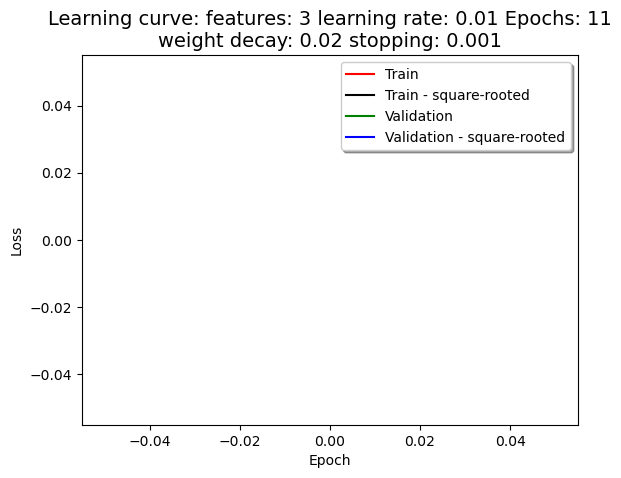

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001



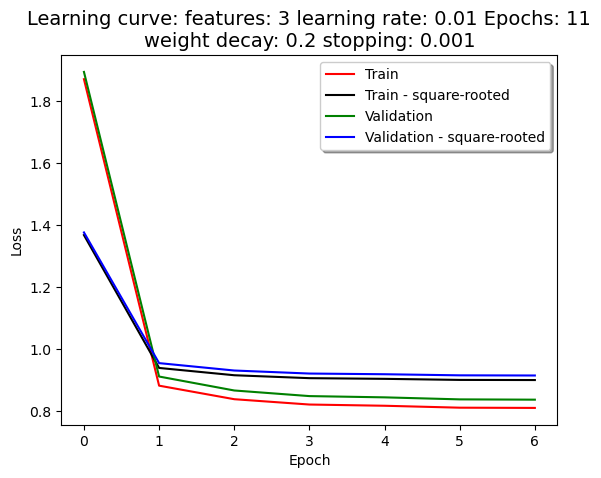

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001



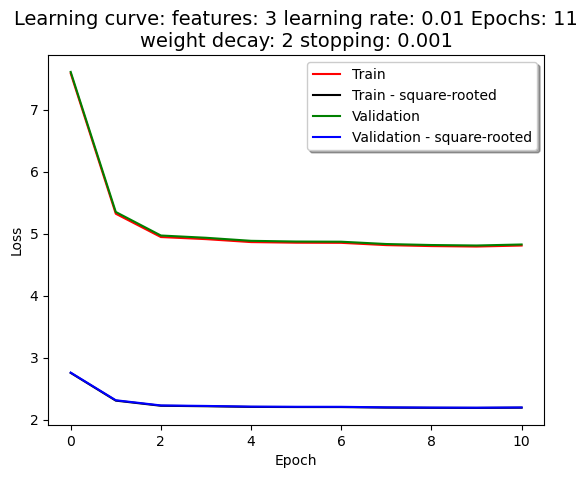

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001



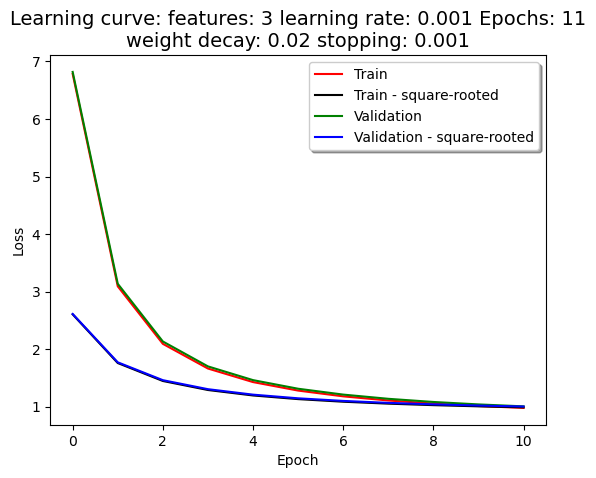

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001



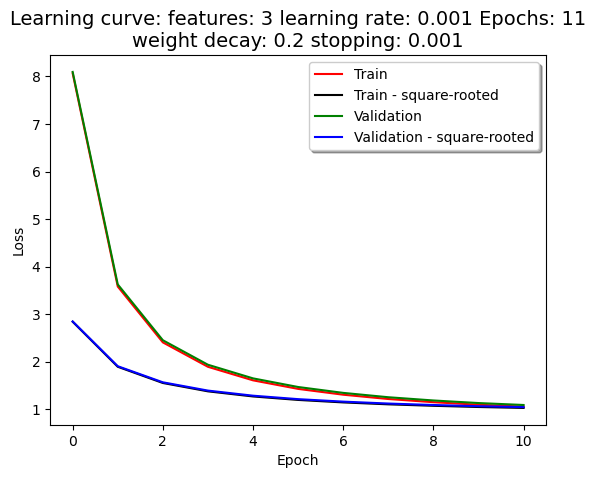

features: 3
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001



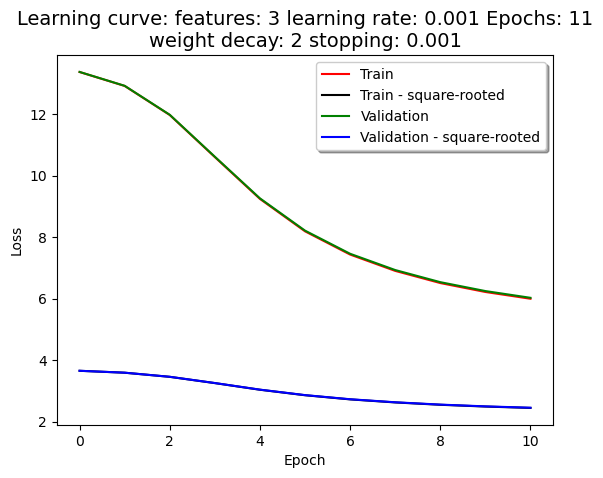

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001



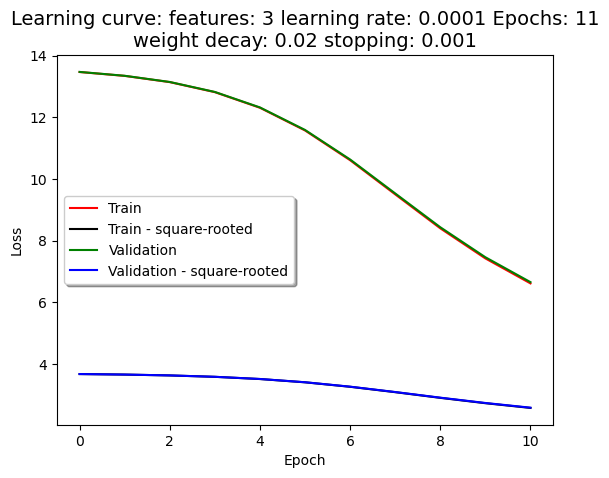

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001



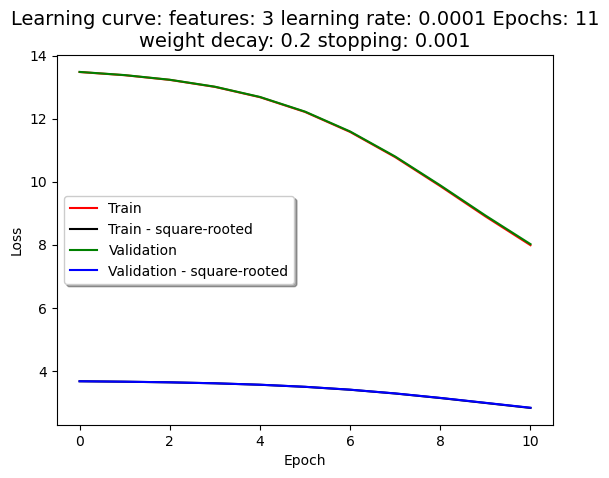

features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001



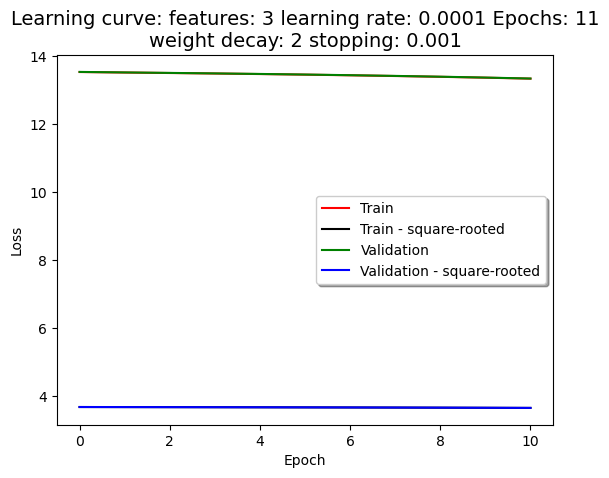

features: 30
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001



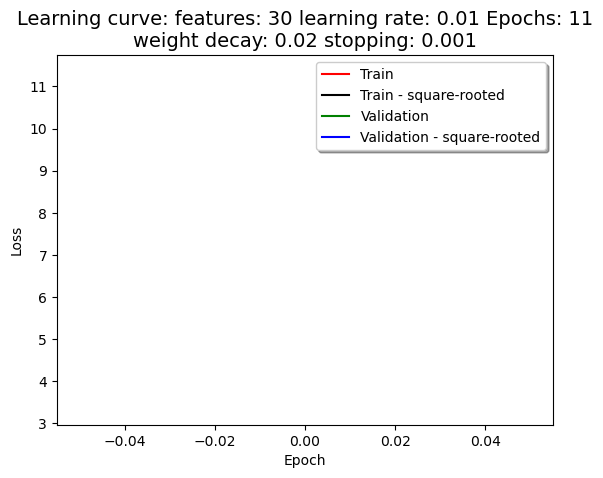

features: 30
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001



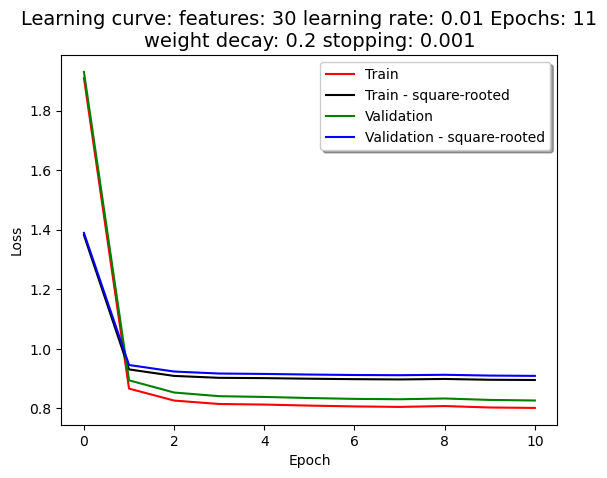

features: 30
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001



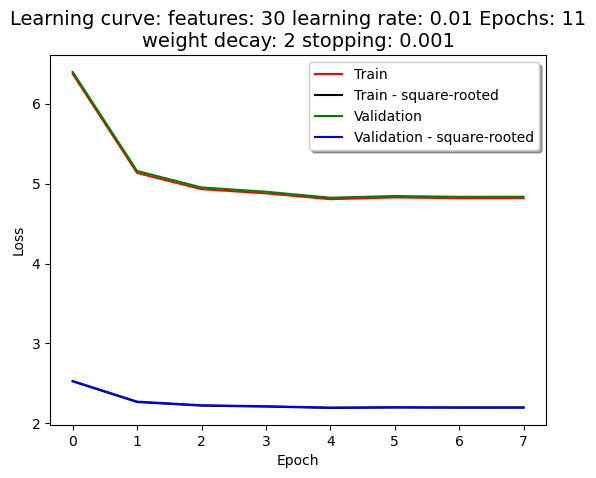

features: 30
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001



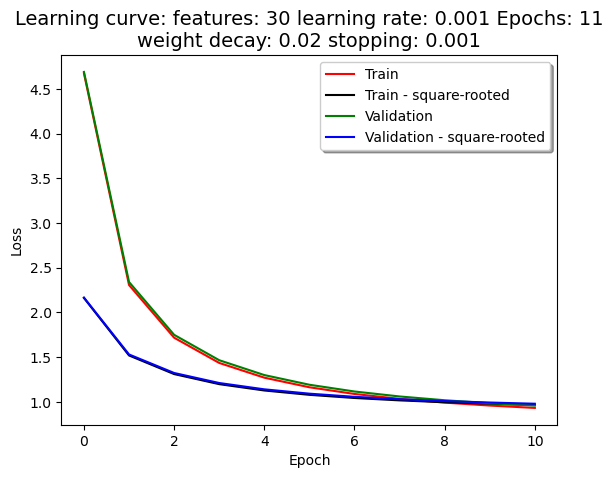

features: 30
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001



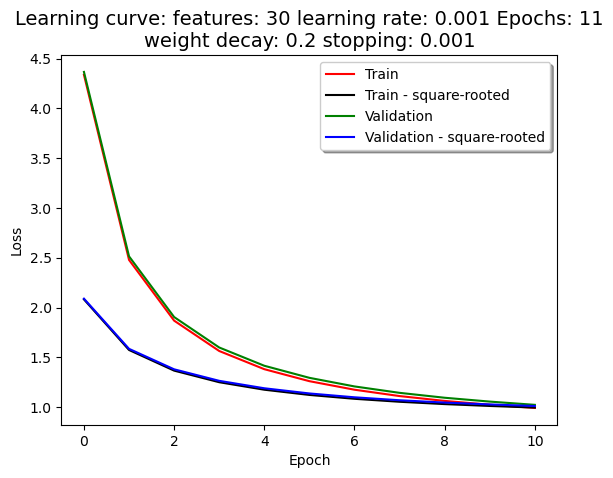

features: 30
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001



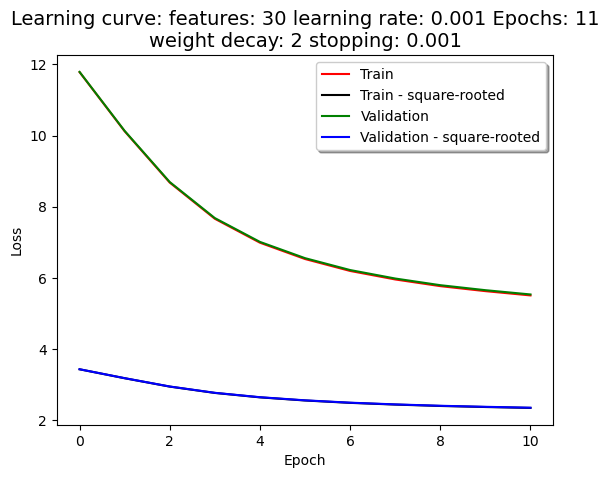

features: 30
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001



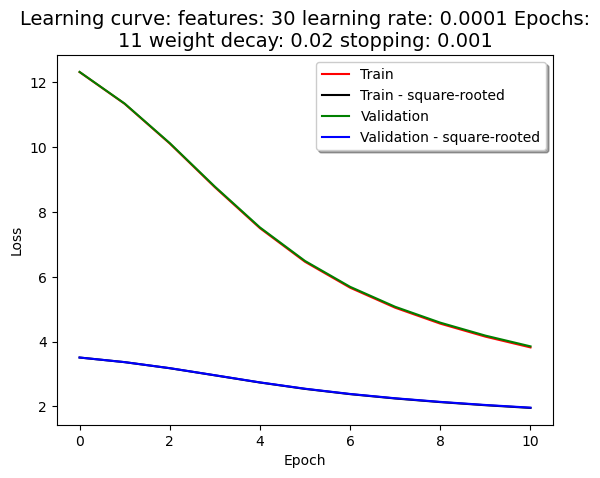

features: 30
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001



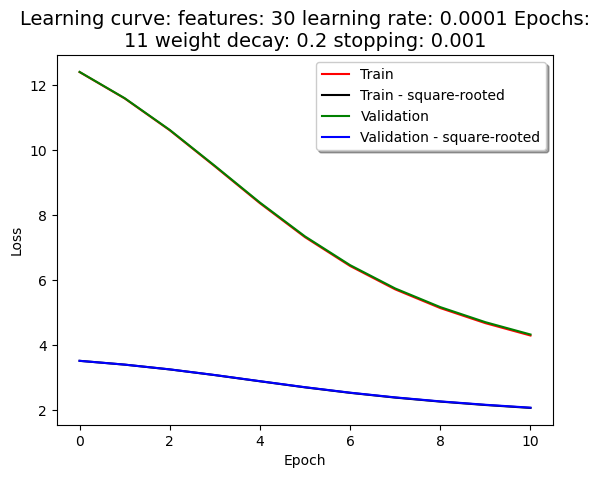

features: 30
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001



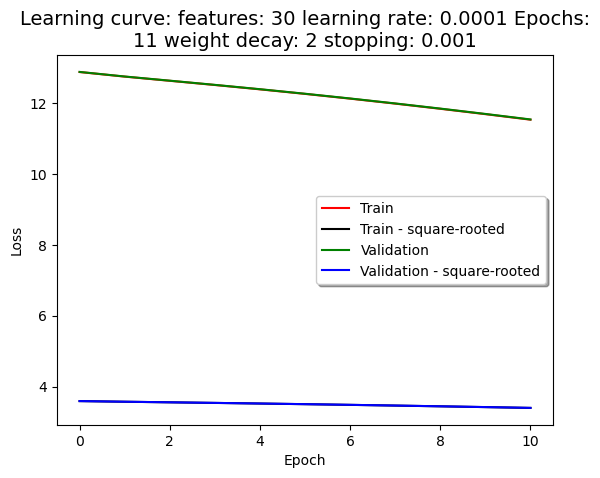

features: 150
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001



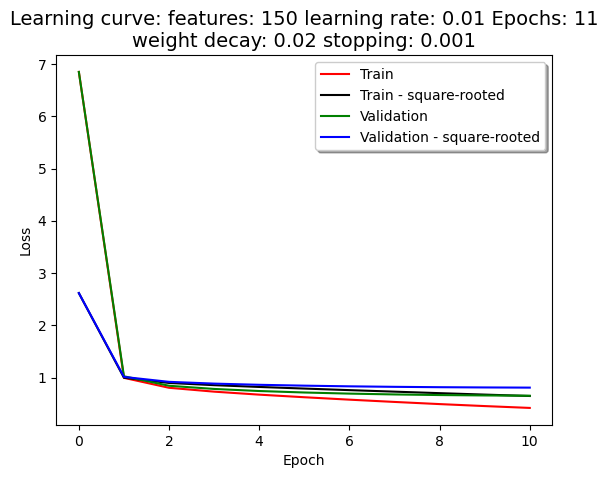

features: 150
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001



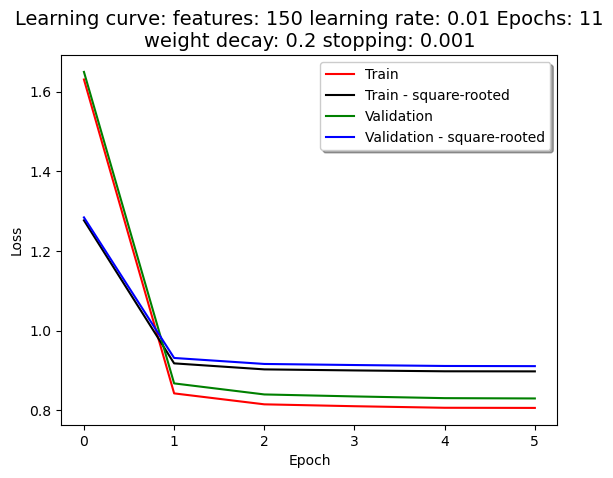

features: 150
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001



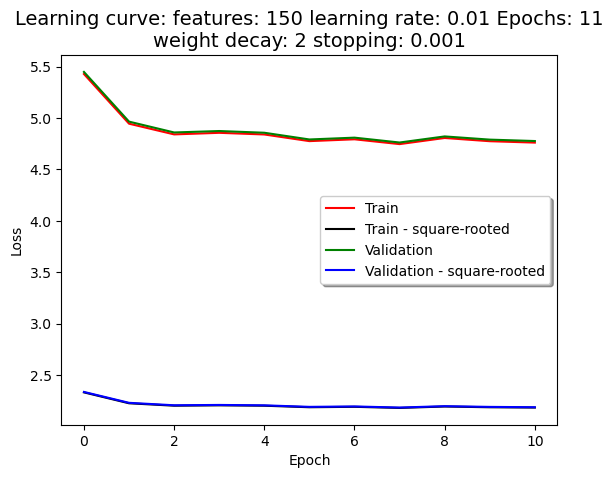

features: 150
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001



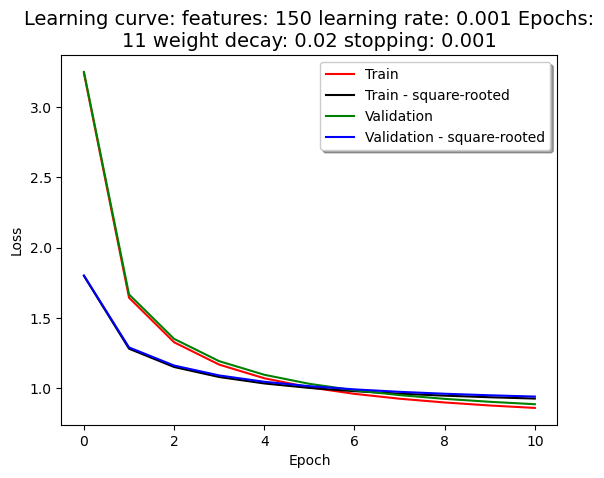

features: 150
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001



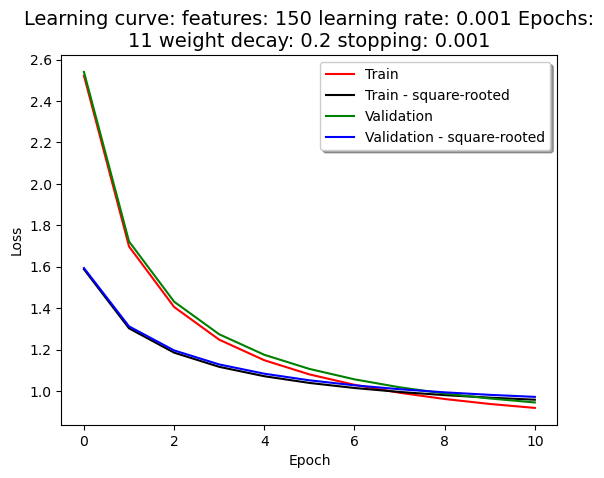

features: 150
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001



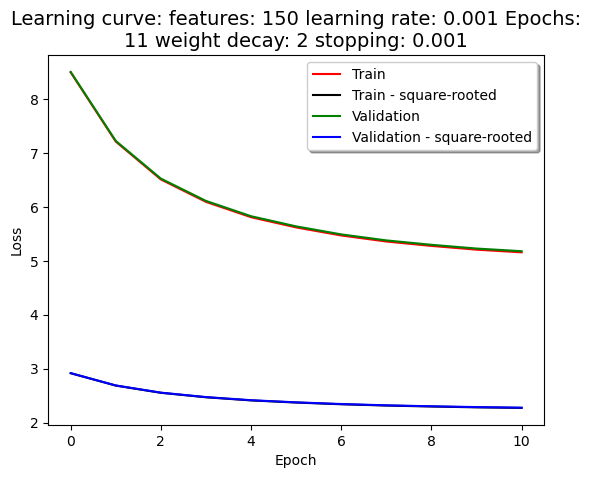

features: 150
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001



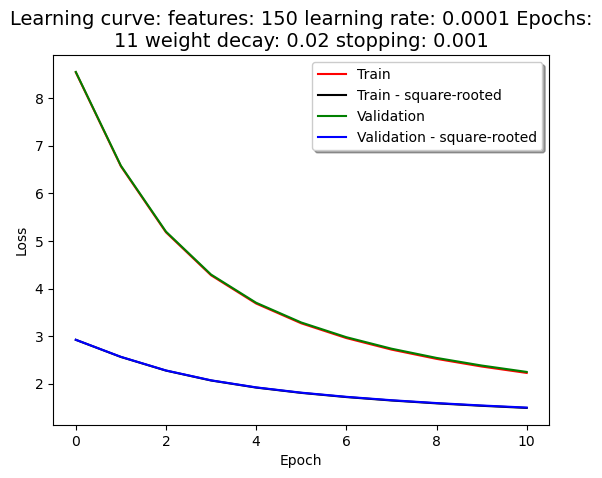

features: 150
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001



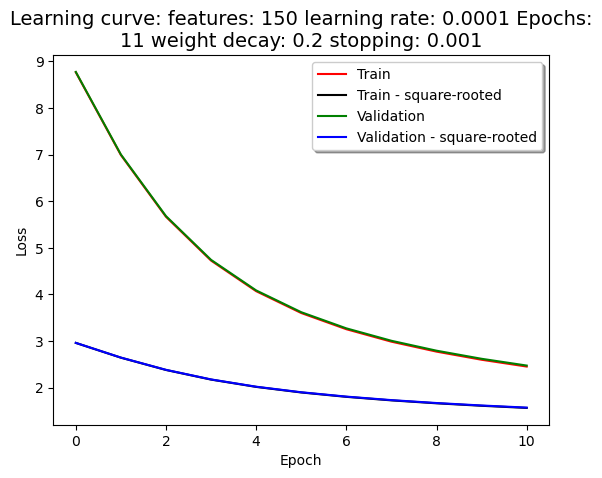

features: 150
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001



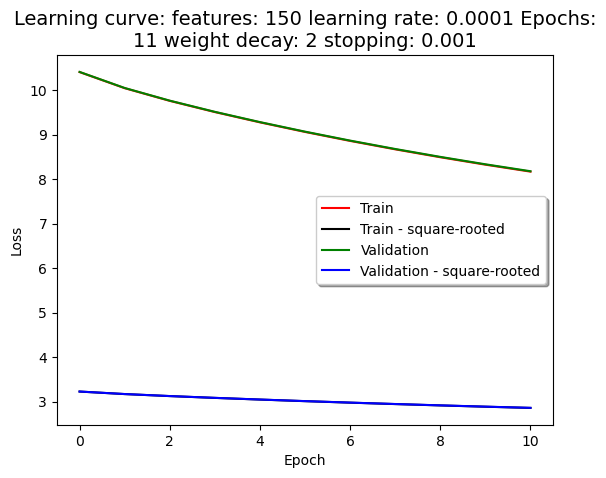

features: 300
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001



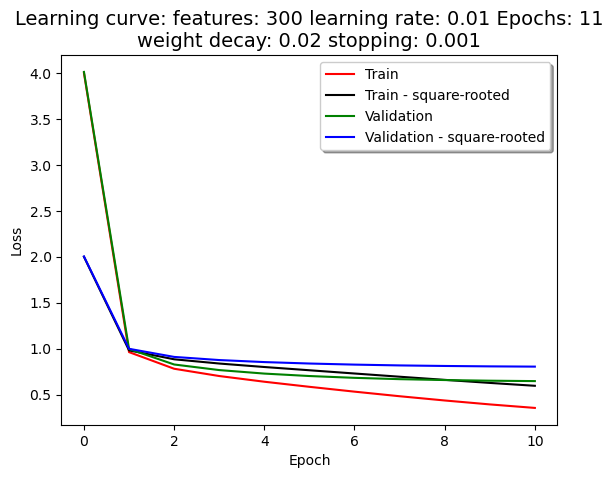

features: 300
learning rate: 0.01
Epochs: 11
weight decay: 0.2
stopping: 0.001



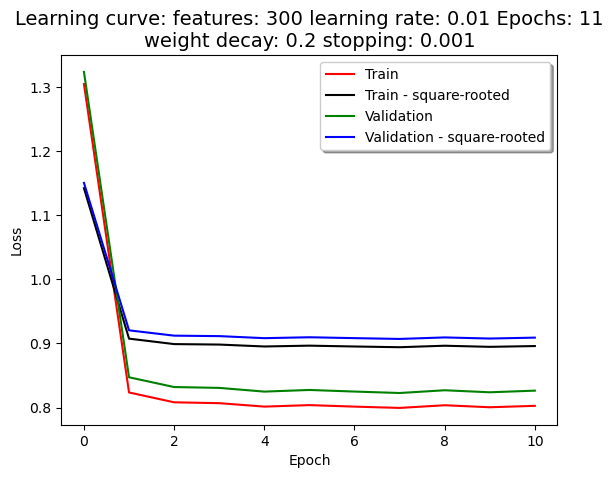

features: 300
learning rate: 0.01
Epochs: 11
weight decay: 2
stopping: 0.001



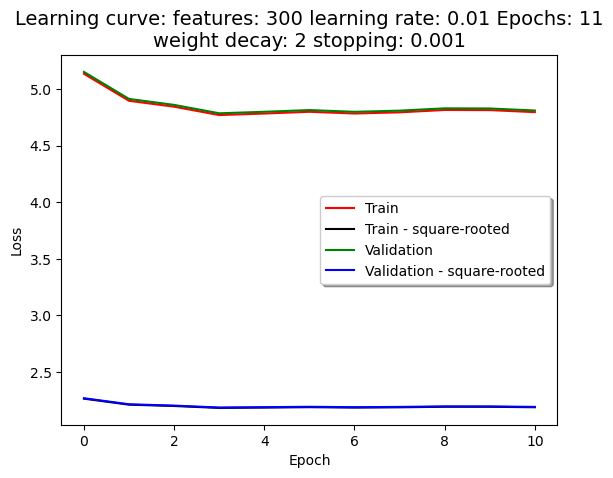

features: 300
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001



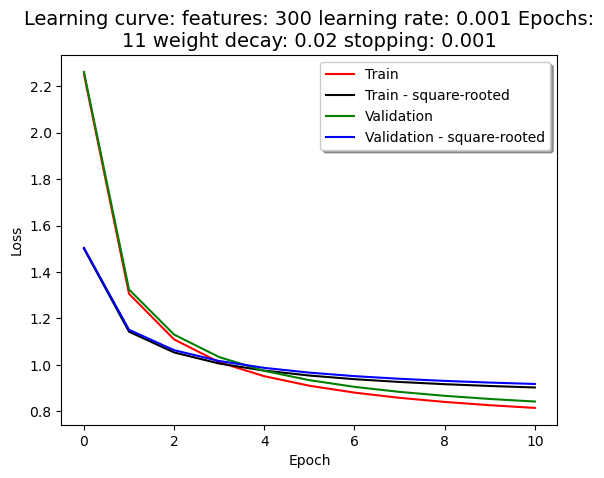

features: 300
learning rate: 0.001
Epochs: 11
weight decay: 0.2
stopping: 0.001



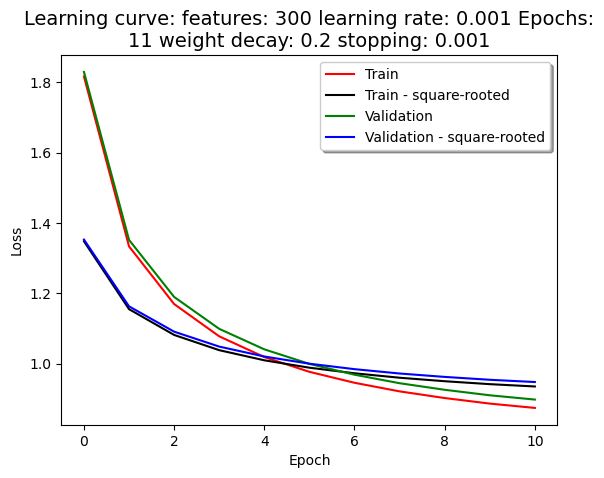

features: 300
learning rate: 0.001
Epochs: 11
weight decay: 2
stopping: 0.001



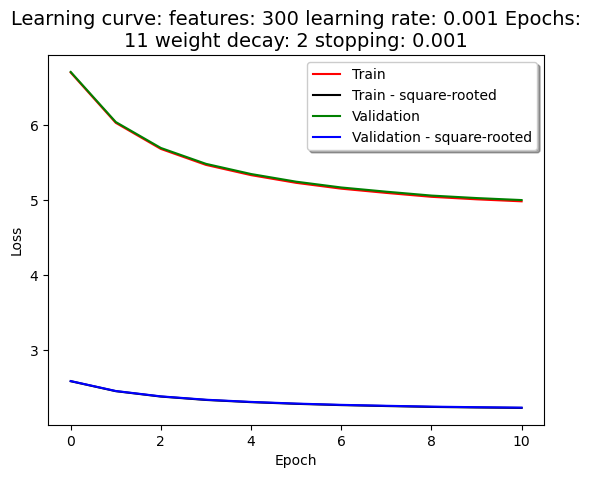

features: 300
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001



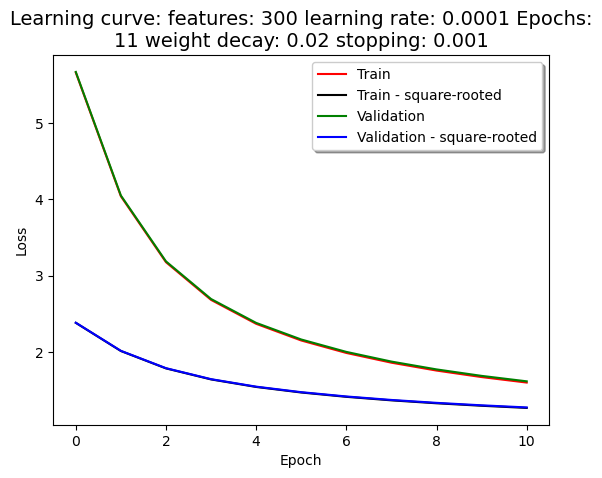

features: 300
learning rate: 0.0001
Epochs: 11
weight decay: 0.2
stopping: 0.001



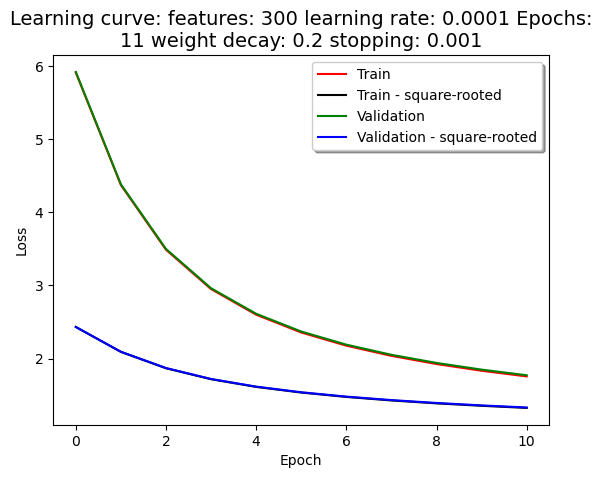

features: 300
learning rate: 0.0001
Epochs: 11
weight decay: 2
stopping: 0.001



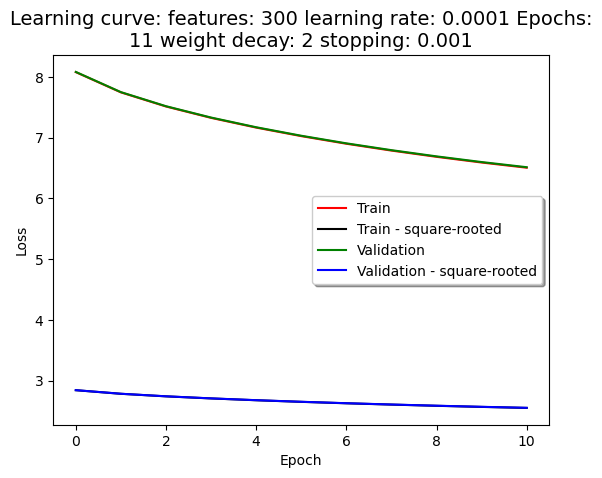

features: 3
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001



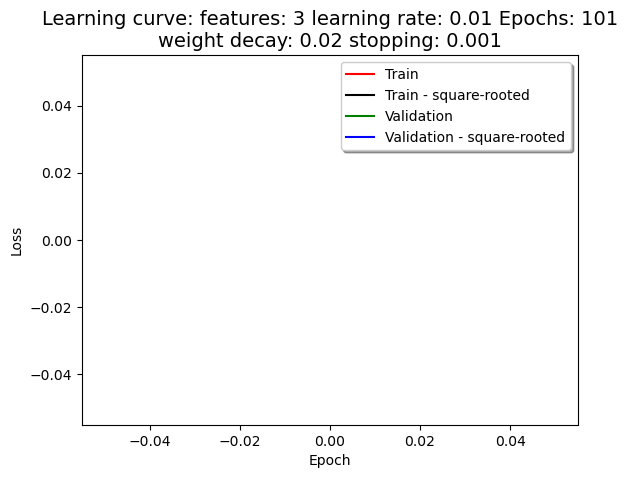

features: 3
learning rate: 0.01
Epochs: 101
weight decay: 0.2
stopping: 0.001



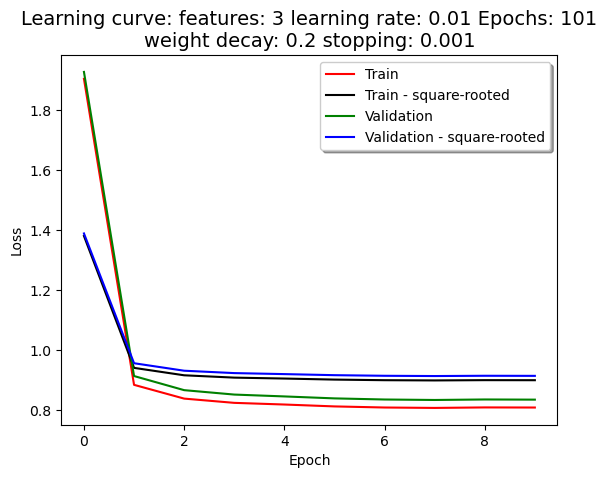

features: 3
learning rate: 0.01
Epochs: 101
weight decay: 2
stopping: 0.001



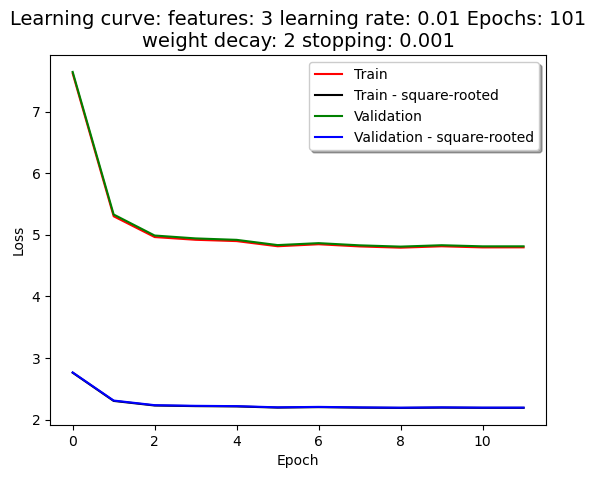

features: 3
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001



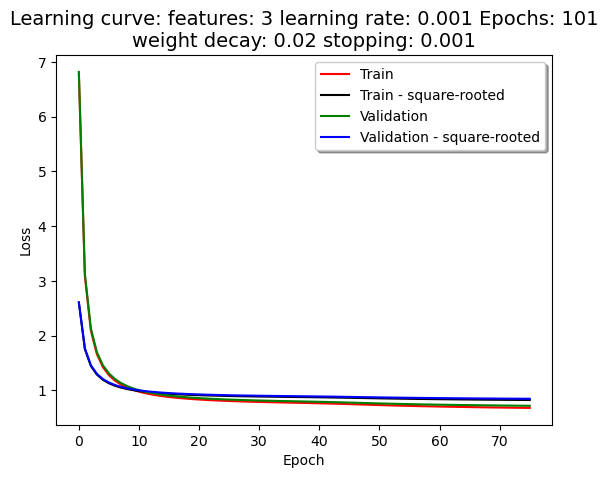

features: 3
learning rate: 0.001
Epochs: 101
weight decay: 0.2
stopping: 0.001



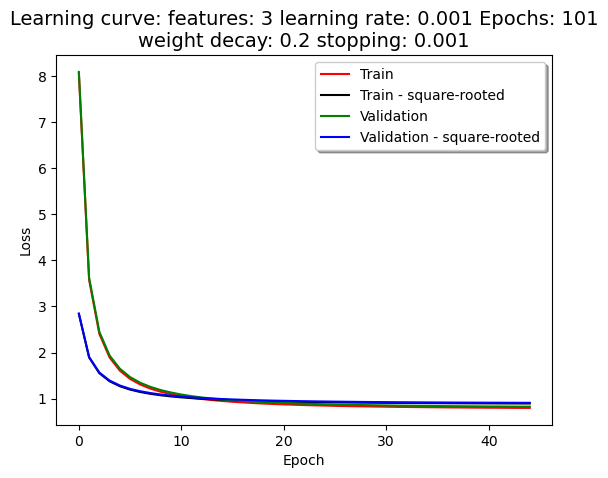

features: 3
learning rate: 0.001
Epochs: 101
weight decay: 2
stopping: 0.001



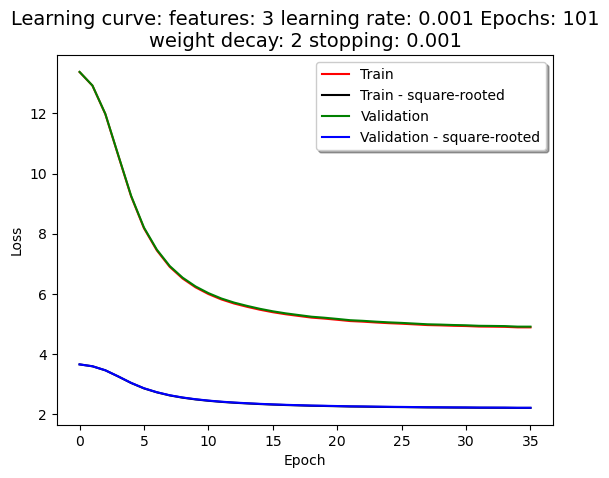

features: 3
learning rate: 0.0001
Epochs: 101
weight decay: 0.02
stopping: 0.001



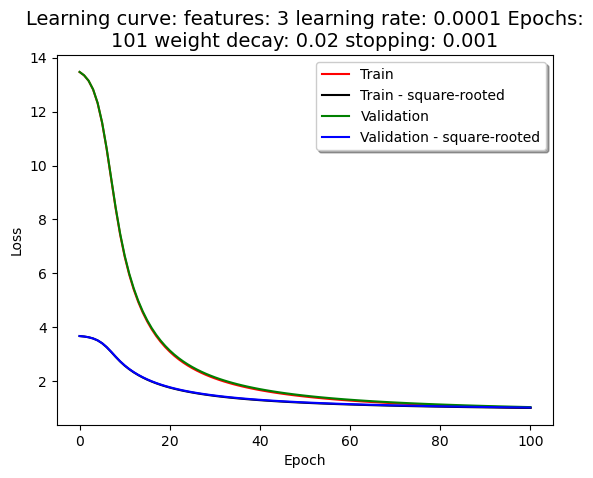

features: 3
learning rate: 0.0001
Epochs: 101
weight decay: 0.2
stopping: 0.001



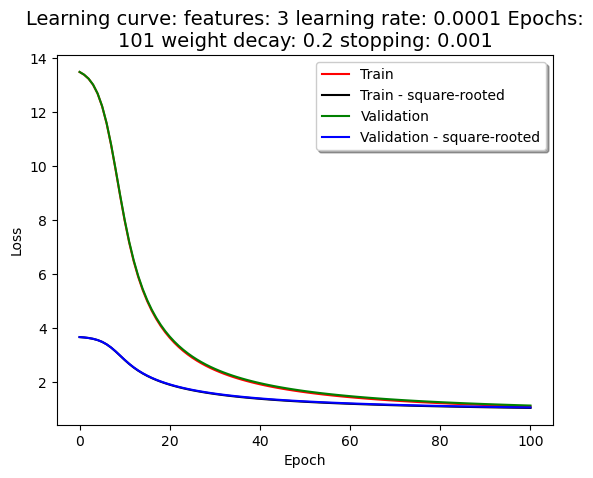

features: 3
learning rate: 0.0001
Epochs: 101
weight decay: 2
stopping: 0.001



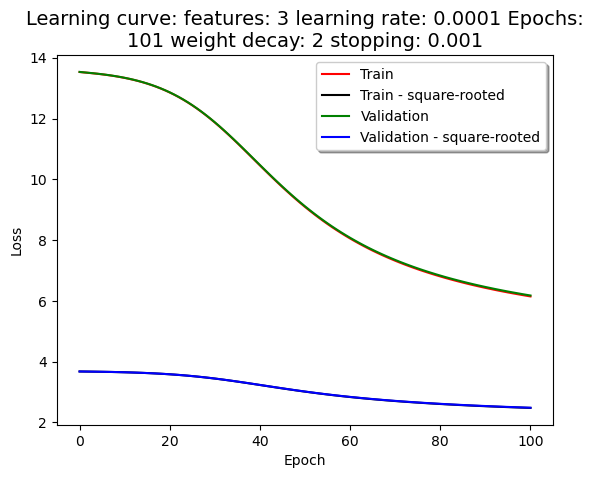

features: 30
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001



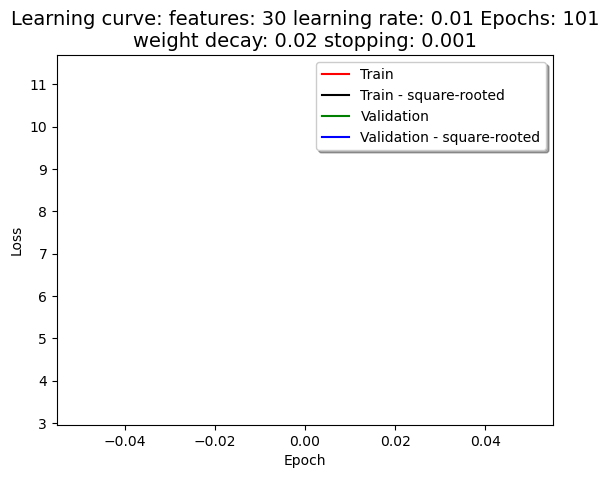

features: 30
learning rate: 0.01
Epochs: 101
weight decay: 0.2
stopping: 0.001



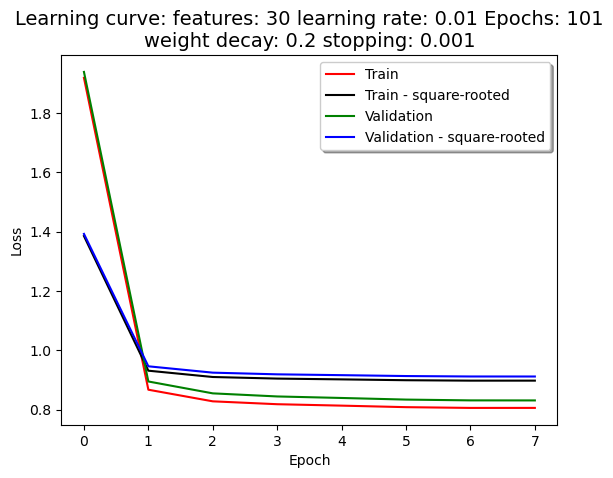

features: 30
learning rate: 0.01
Epochs: 101
weight decay: 2
stopping: 0.001



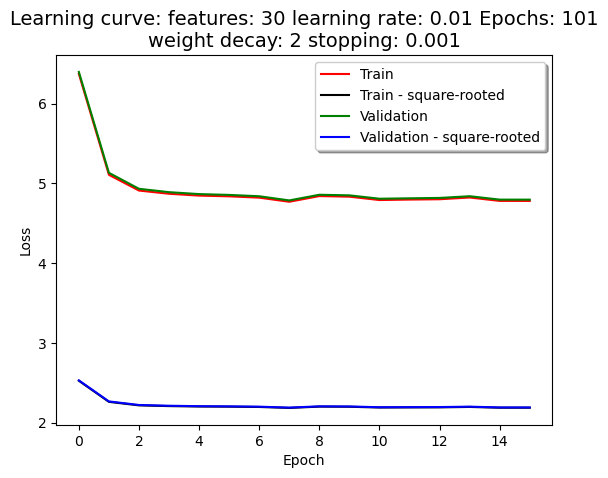

features: 30
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001



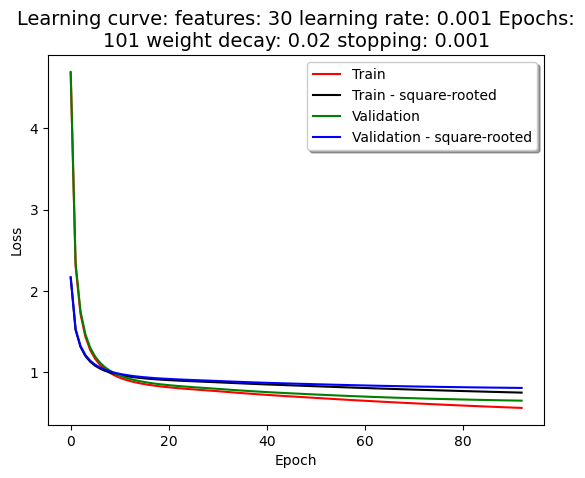

features: 30
learning rate: 0.001
Epochs: 101
weight decay: 0.2
stopping: 0.001



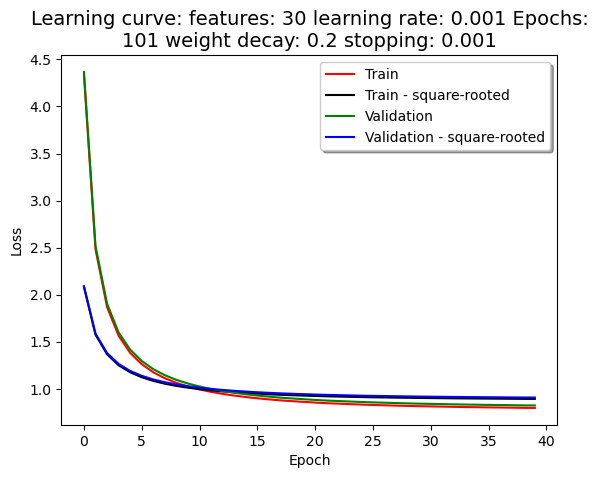

features: 30
learning rate: 0.001
Epochs: 101
weight decay: 2
stopping: 0.001



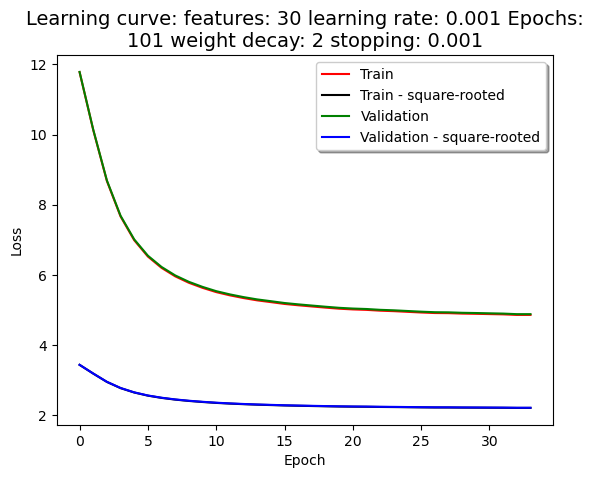

features: 30
learning rate: 0.0001
Epochs: 101
weight decay: 0.02
stopping: 0.001



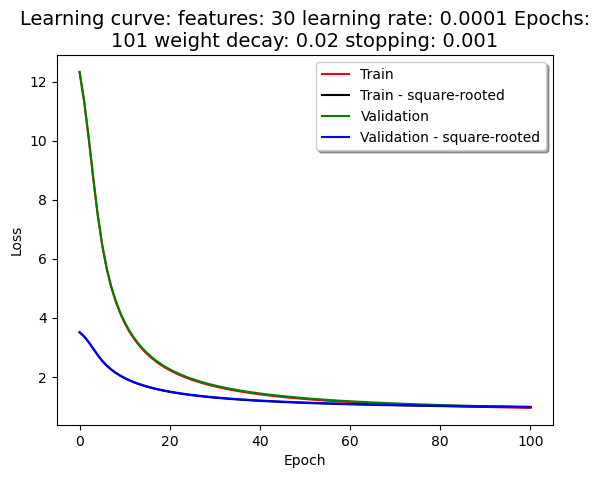

features: 30
learning rate: 0.0001
Epochs: 101
weight decay: 0.2
stopping: 0.001



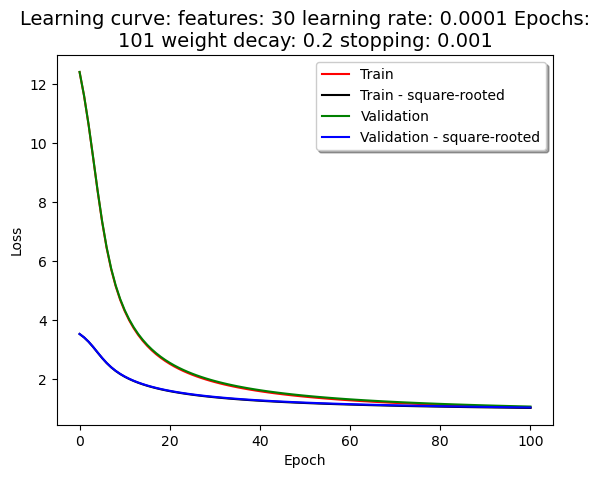

features: 30
learning rate: 0.0001
Epochs: 101
weight decay: 2
stopping: 0.001



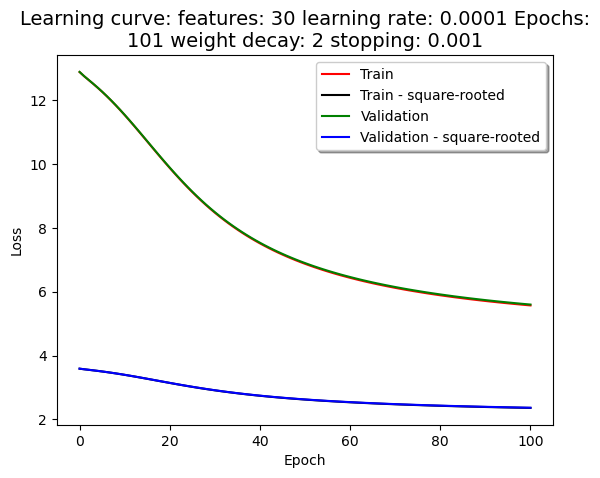

features: 150
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001



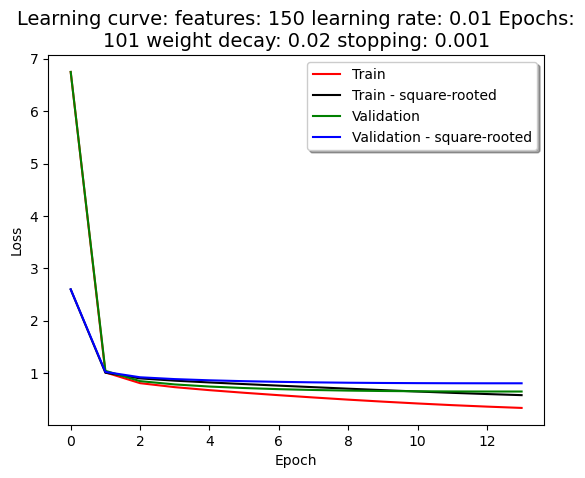

features: 150
learning rate: 0.01
Epochs: 101
weight decay: 0.2
stopping: 0.001



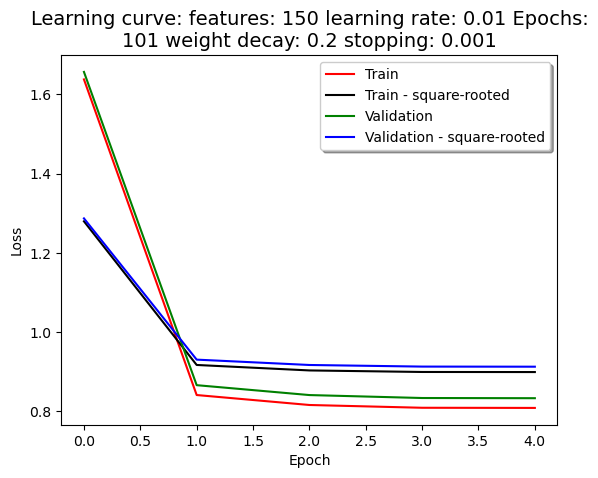

features: 150
learning rate: 0.01
Epochs: 101
weight decay: 2
stopping: 0.001



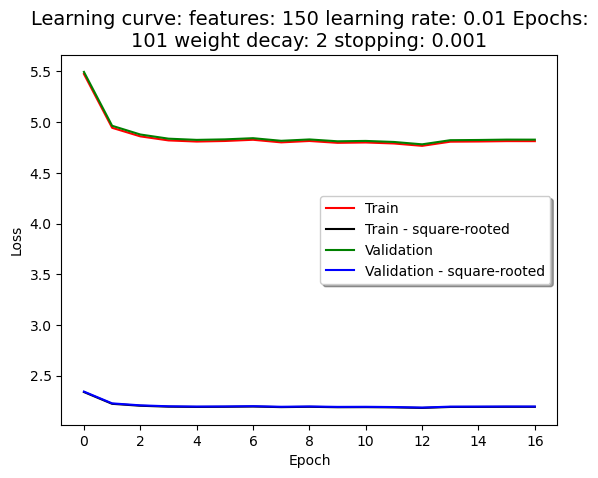

features: 150
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001



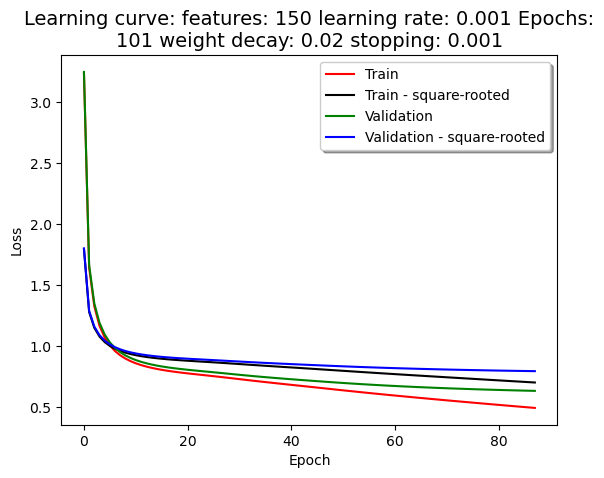

features: 150
learning rate: 0.001
Epochs: 101
weight decay: 0.2
stopping: 0.001



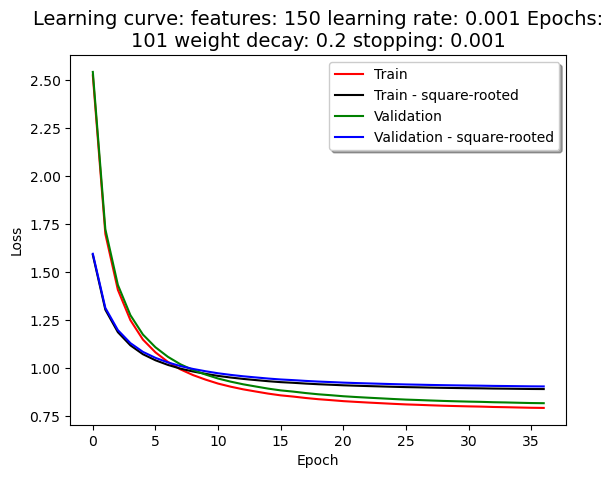

features: 150
learning rate: 0.001
Epochs: 101
weight decay: 2
stopping: 0.001



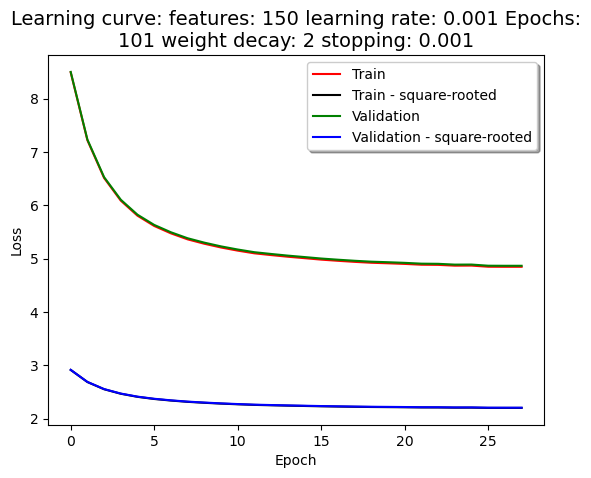

features: 150
learning rate: 0.0001
Epochs: 101
weight decay: 0.02
stopping: 0.001



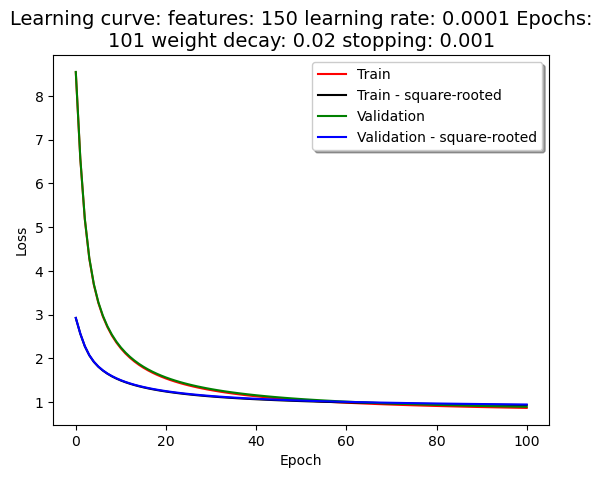

features: 150
learning rate: 0.0001
Epochs: 101
weight decay: 0.2
stopping: 0.001



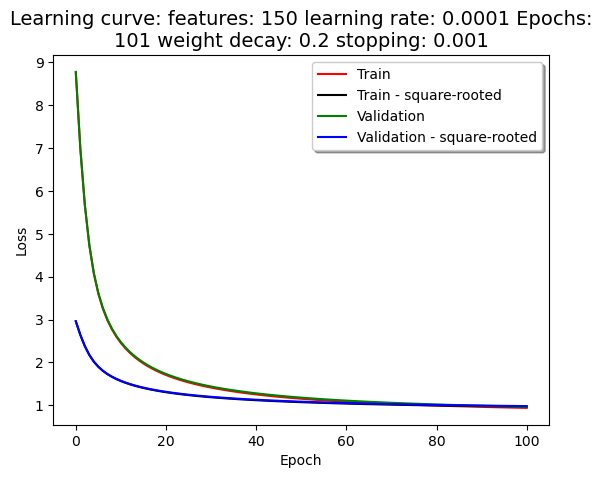

features: 150
learning rate: 0.0001
Epochs: 101
weight decay: 2
stopping: 0.001



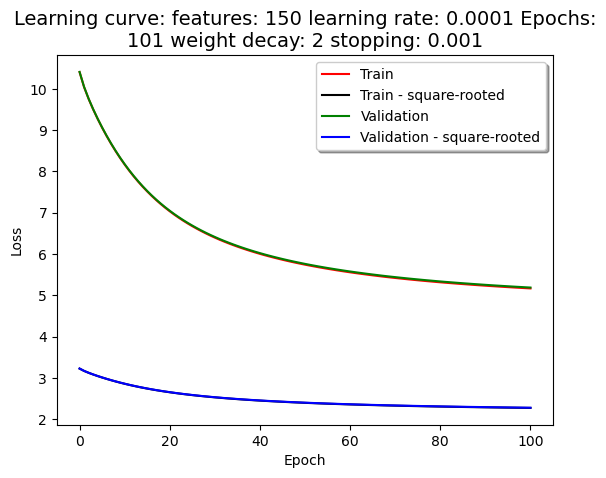

features: 300
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001



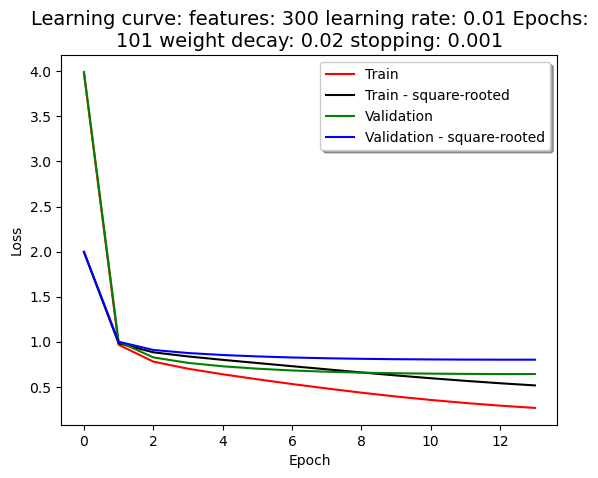

features: 300
learning rate: 0.01
Epochs: 101
weight decay: 0.2
stopping: 0.001



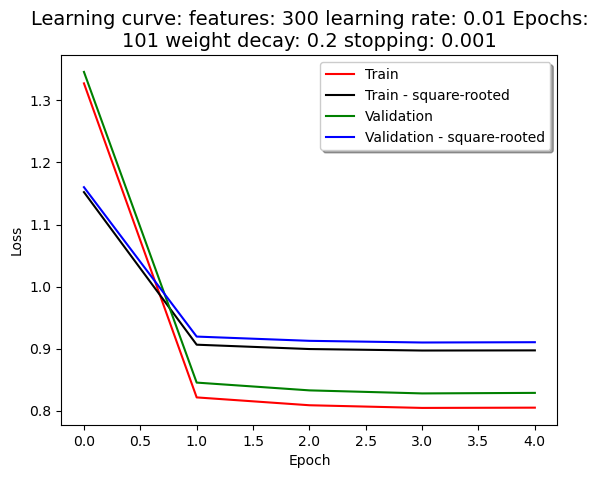

features: 300
learning rate: 0.01
Epochs: 101
weight decay: 2
stopping: 0.001



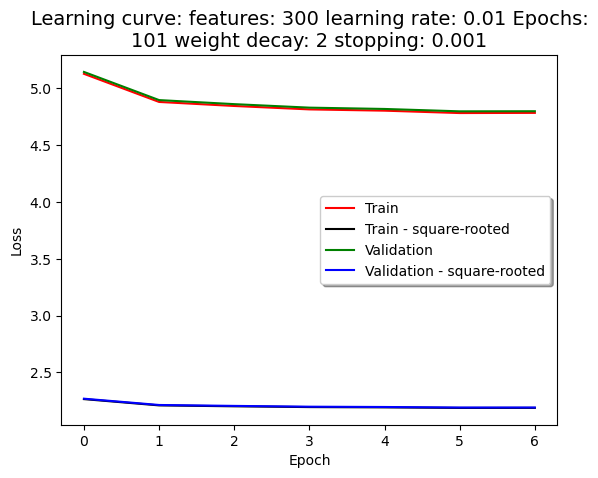

features: 300
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001



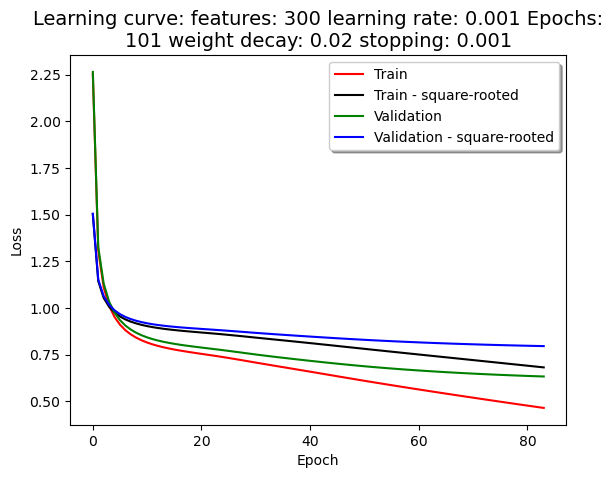

features: 300
learning rate: 0.001
Epochs: 101
weight decay: 0.2
stopping: 0.001



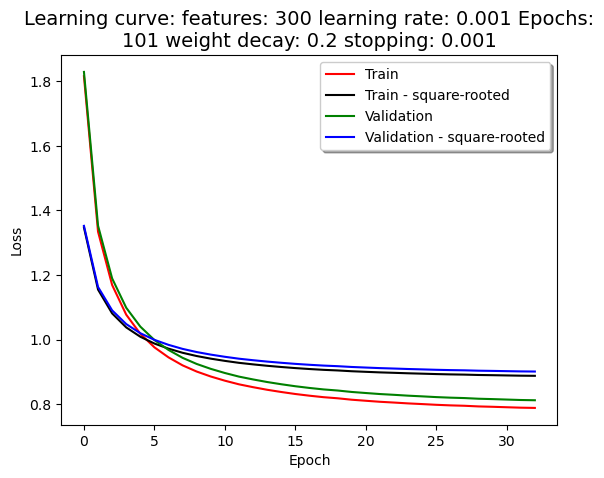

features: 300
learning rate: 0.001
Epochs: 101
weight decay: 2
stopping: 0.001



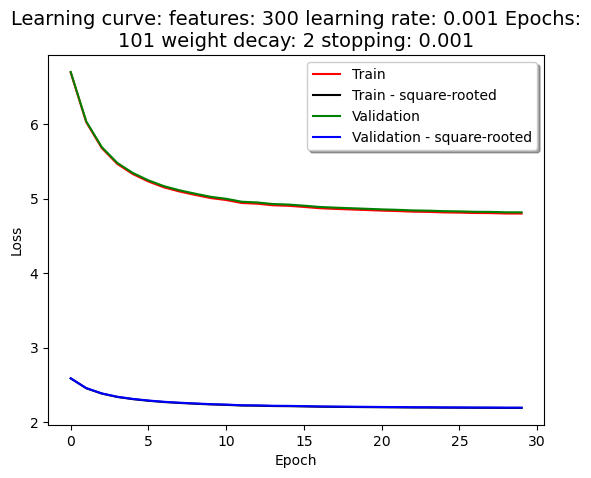

features: 300
learning rate: 0.0001
Epochs: 101
weight decay: 0.02
stopping: 0.001



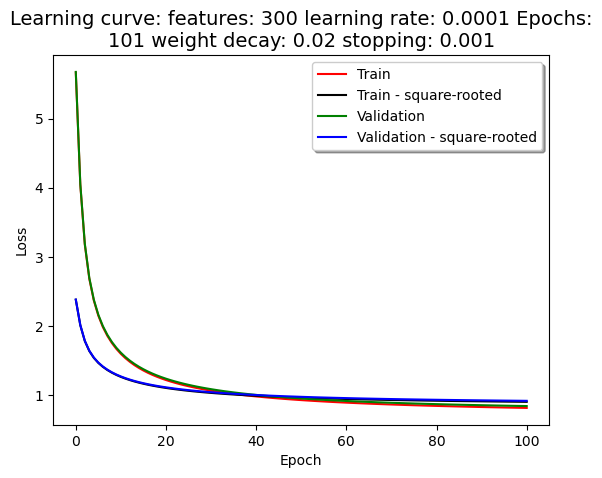

features: 300
learning rate: 0.0001
Epochs: 101
weight decay: 0.2
stopping: 0.001



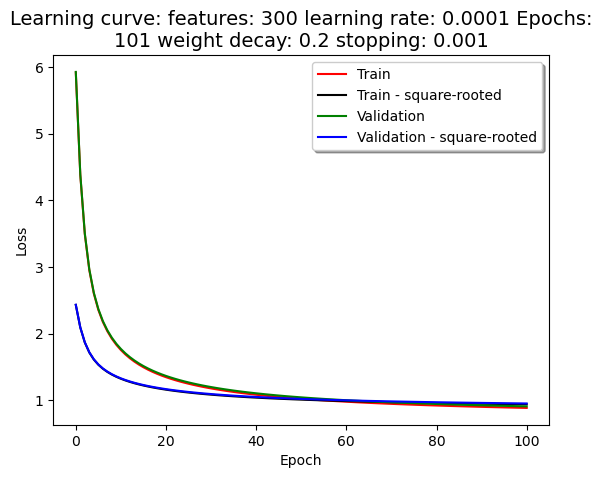

features: 300
learning rate: 0.0001
Epochs: 101
weight decay: 2
stopping: 0.001



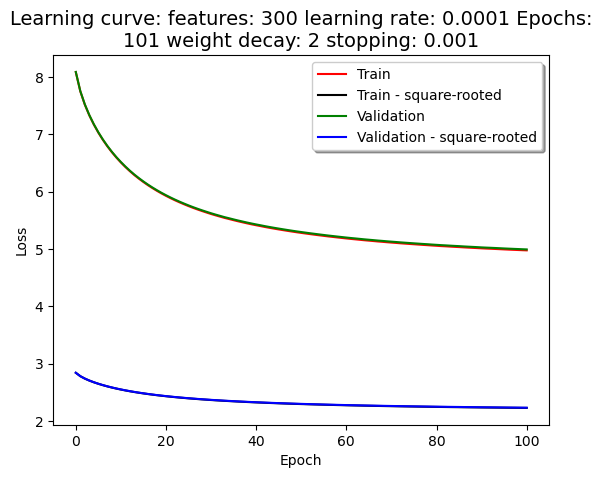

features: 3
learning rate: 0.01
Epochs: 201
weight decay: 0.02
stopping: 0.001



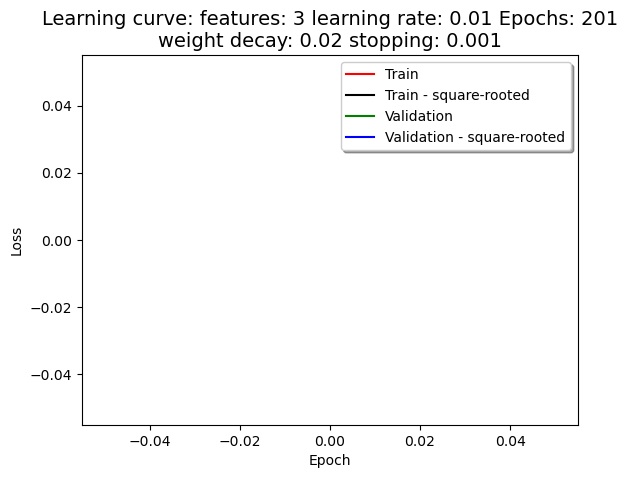

features: 3
learning rate: 0.01
Epochs: 201
weight decay: 0.2
stopping: 0.001



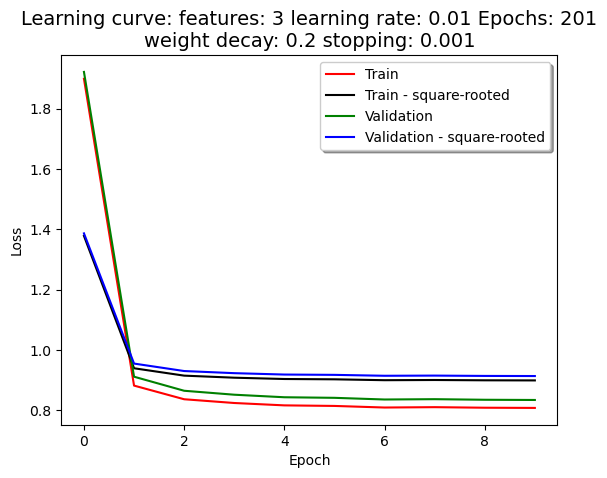

features: 3
learning rate: 0.01
Epochs: 201
weight decay: 2
stopping: 0.001



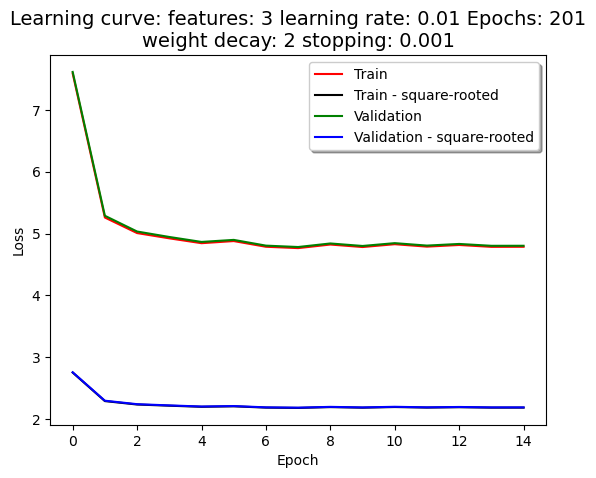

features: 3
learning rate: 0.001
Epochs: 201
weight decay: 0.02
stopping: 0.001



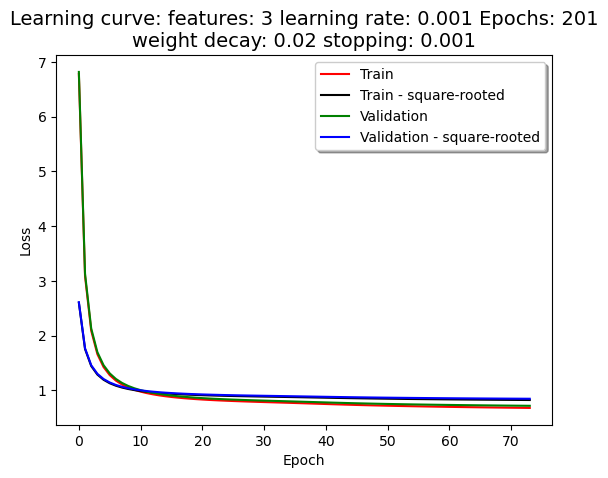

features: 3
learning rate: 0.001
Epochs: 201
weight decay: 0.2
stopping: 0.001



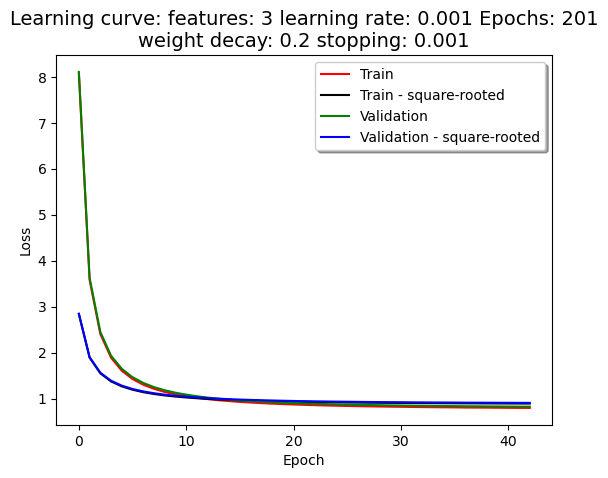

features: 3
learning rate: 0.001
Epochs: 201
weight decay: 2
stopping: 0.001



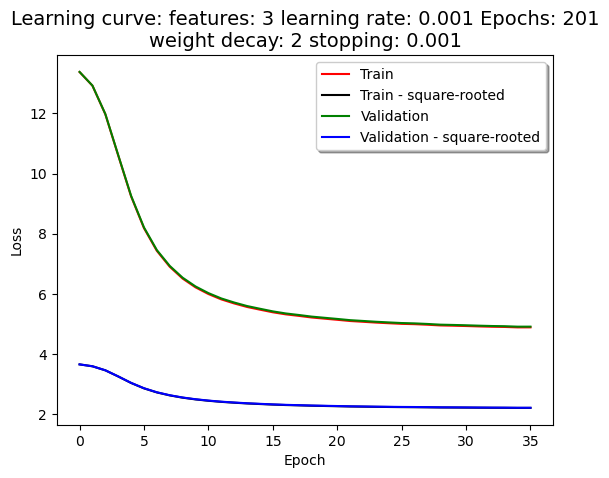

features: 3
learning rate: 0.0001
Epochs: 201
weight decay: 0.02
stopping: 0.001



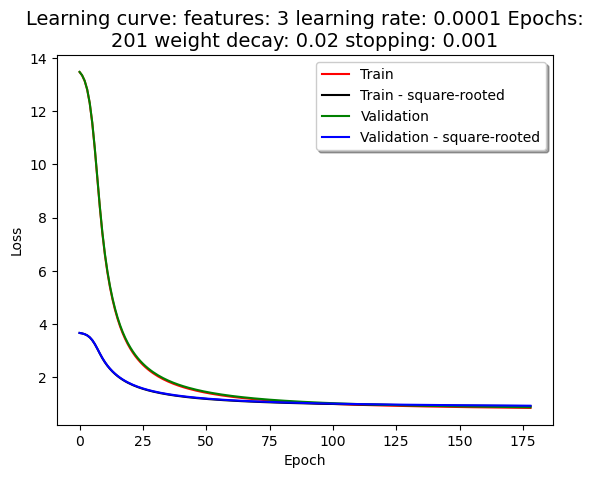

features: 3
learning rate: 0.0001
Epochs: 201
weight decay: 0.2
stopping: 0.001



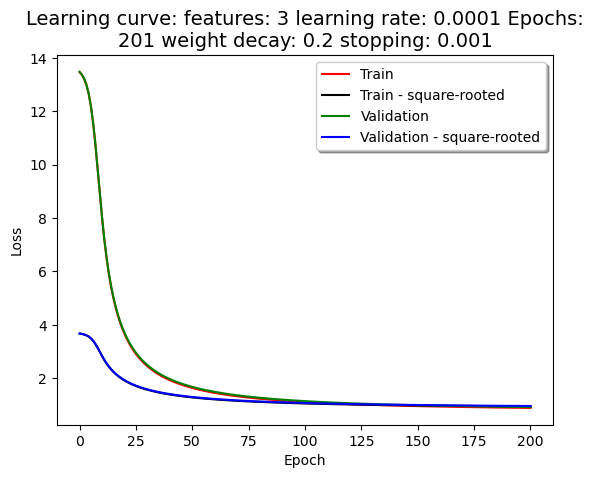

features: 3
learning rate: 0.0001
Epochs: 201
weight decay: 2
stopping: 0.001



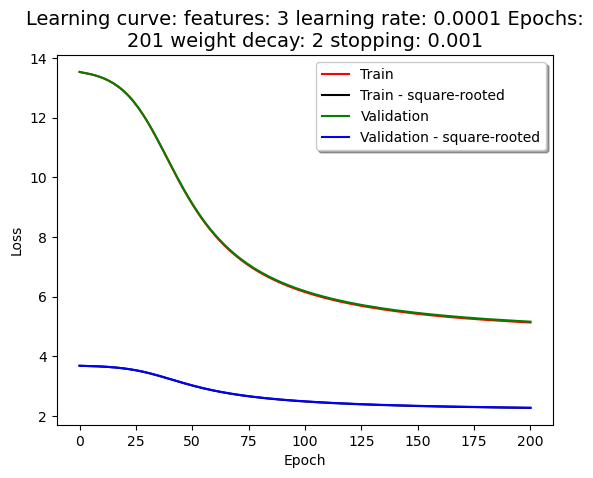

features: 30
learning rate: 0.01
Epochs: 201
weight decay: 0.02
stopping: 0.001



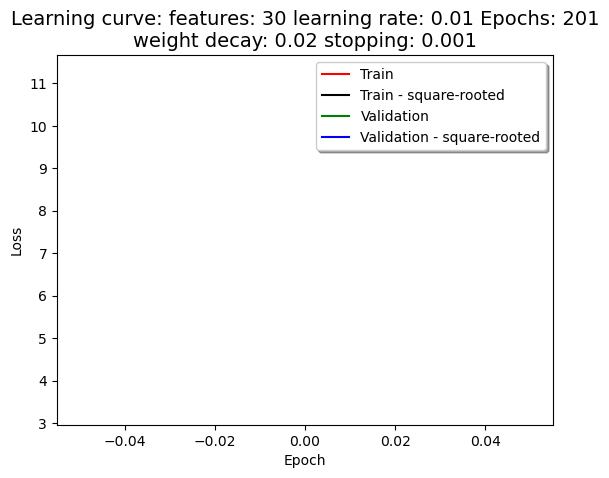

features: 30
learning rate: 0.01
Epochs: 201
weight decay: 0.2
stopping: 0.001



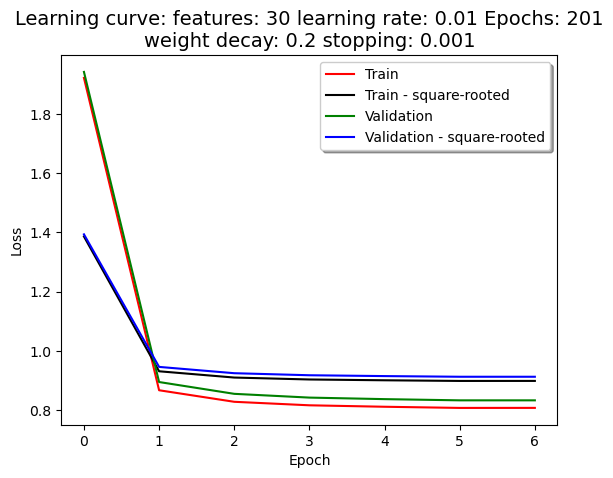

features: 30
learning rate: 0.01
Epochs: 201
weight decay: 2
stopping: 0.001



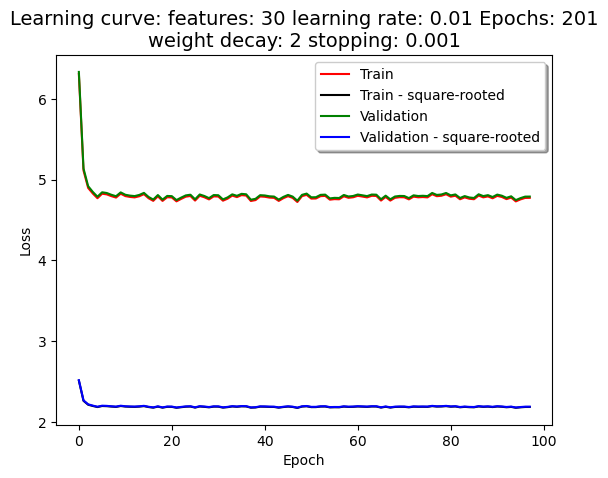

features: 30
learning rate: 0.001
Epochs: 201
weight decay: 0.02
stopping: 0.001



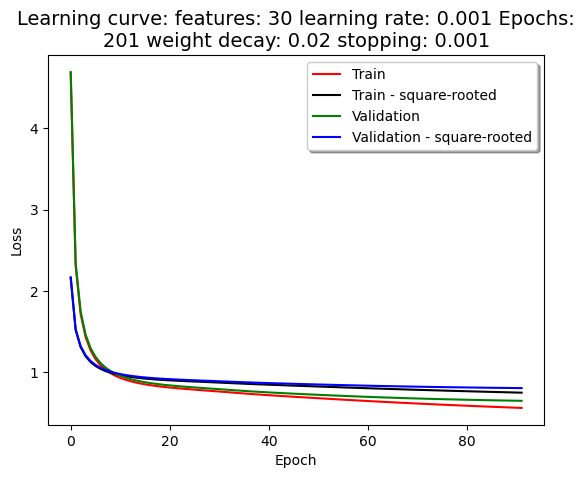

features: 30
learning rate: 0.001
Epochs: 201
weight decay: 0.2
stopping: 0.001



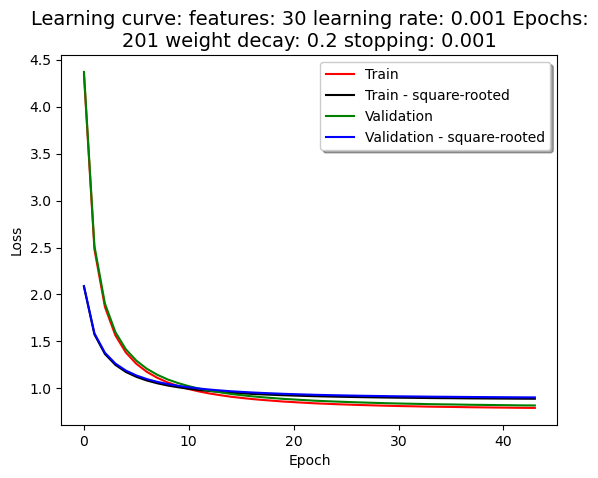

features: 30
learning rate: 0.001
Epochs: 201
weight decay: 2
stopping: 0.001



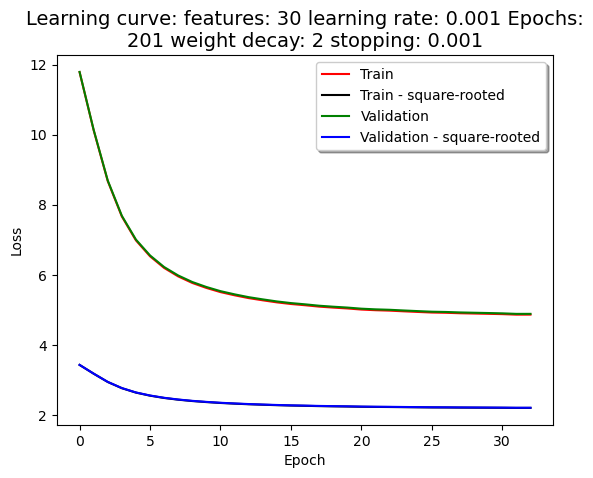

features: 30
learning rate: 0.0001
Epochs: 201
weight decay: 0.02
stopping: 0.001



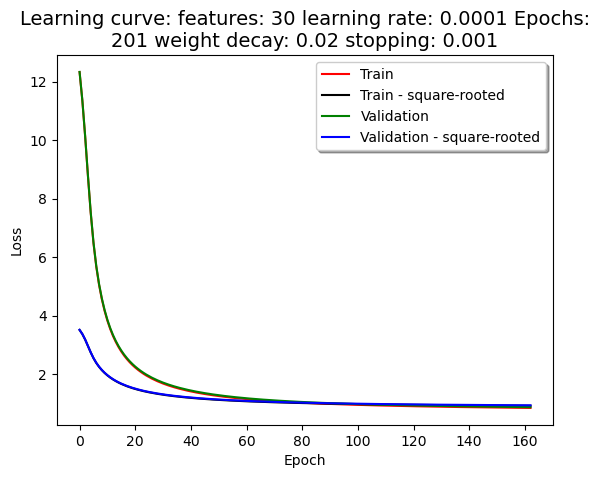

features: 30
learning rate: 0.0001
Epochs: 201
weight decay: 0.2
stopping: 0.001



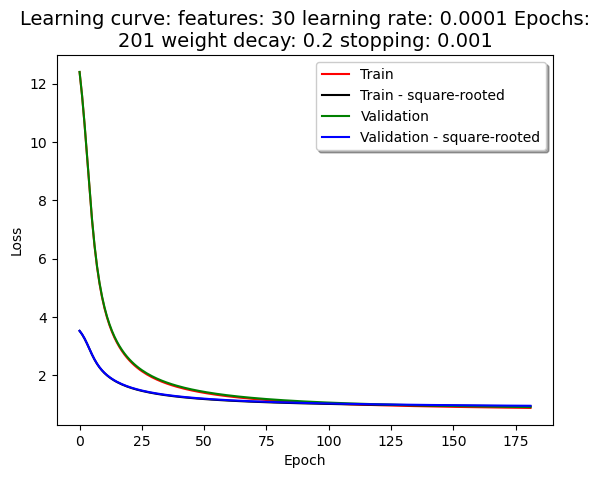

features: 30
learning rate: 0.0001
Epochs: 201
weight decay: 2
stopping: 0.001



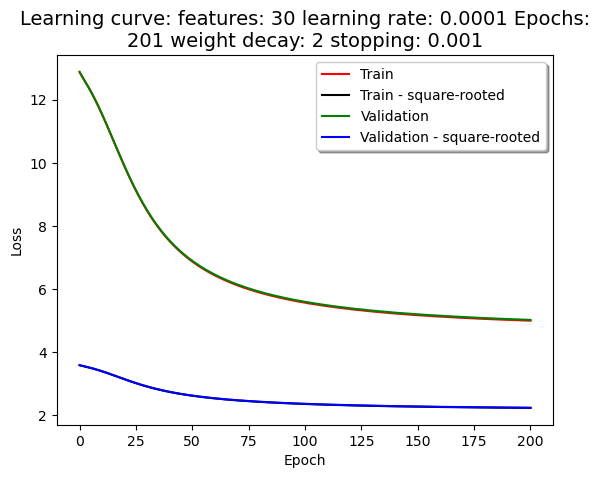

features: 150
learning rate: 0.01
Epochs: 201
weight decay: 0.02
stopping: 0.001



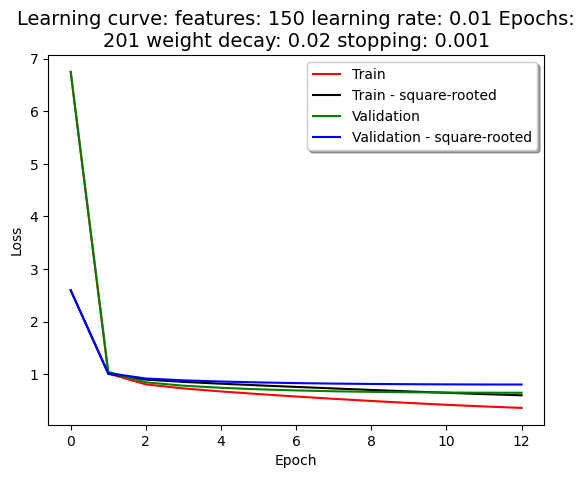

features: 150
learning rate: 0.01
Epochs: 201
weight decay: 0.2
stopping: 0.001



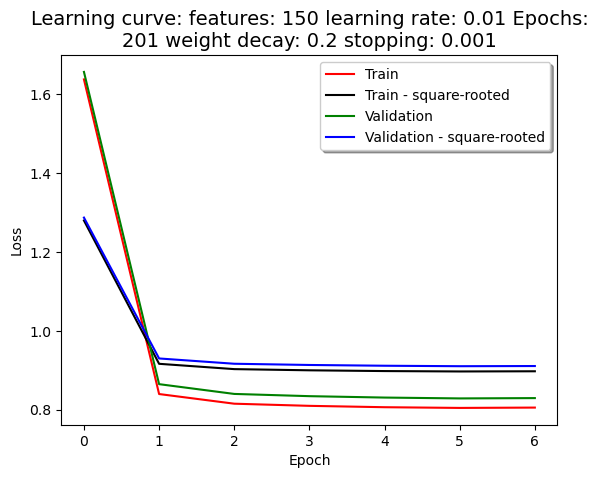

features: 150
learning rate: 0.01
Epochs: 201
weight decay: 2
stopping: 0.001



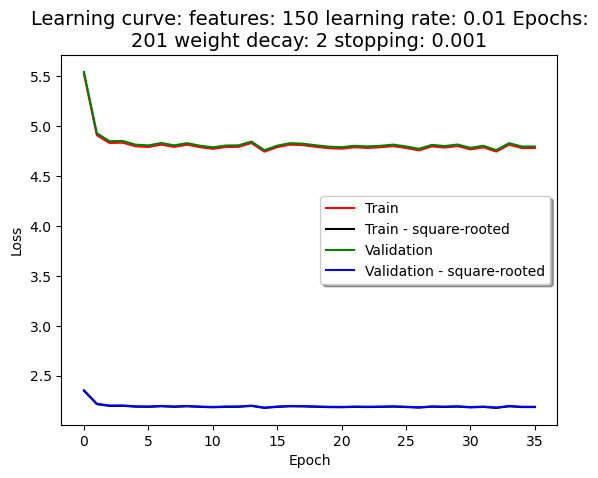

features: 150
learning rate: 0.001
Epochs: 201
weight decay: 0.02
stopping: 0.001



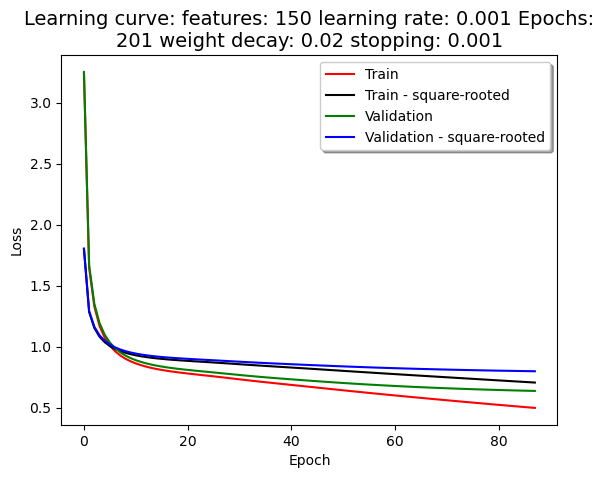

features: 150
learning rate: 0.001
Epochs: 201
weight decay: 0.2
stopping: 0.001



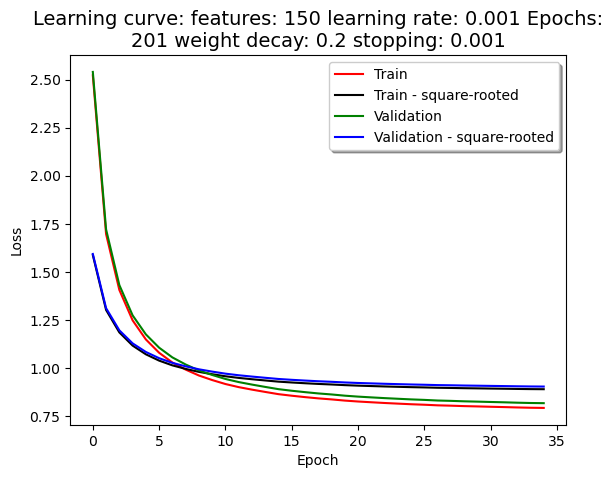

features: 150
learning rate: 0.001
Epochs: 201
weight decay: 2
stopping: 0.001



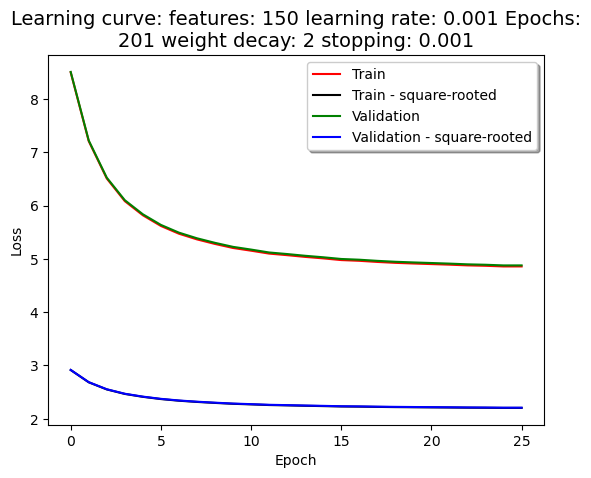

features: 150
learning rate: 0.0001
Epochs: 201
weight decay: 0.02
stopping: 0.001



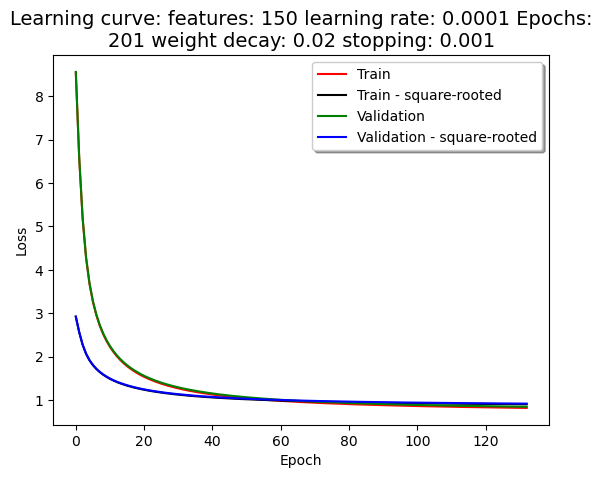

features: 150
learning rate: 0.0001
Epochs: 201
weight decay: 0.2
stopping: 0.001



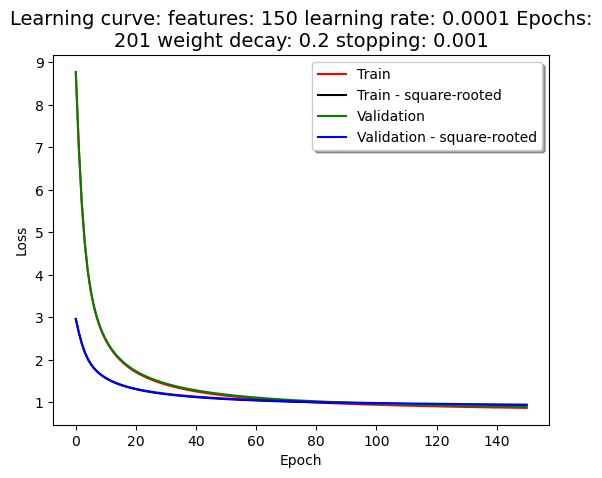

features: 150
learning rate: 0.0001
Epochs: 201
weight decay: 2
stopping: 0.001



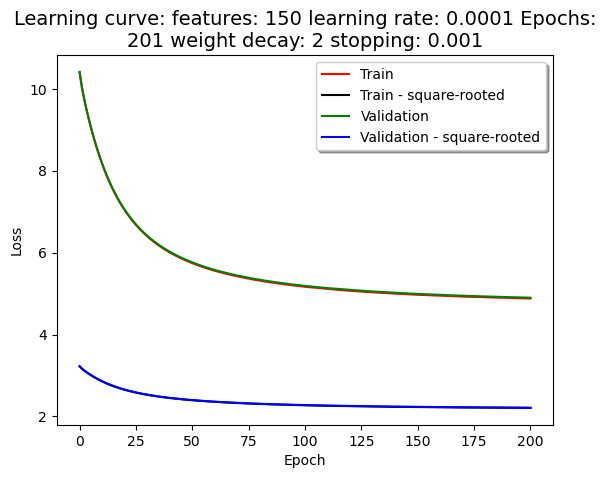

features: 300
learning rate: 0.01
Epochs: 201
weight decay: 0.02
stopping: 0.001



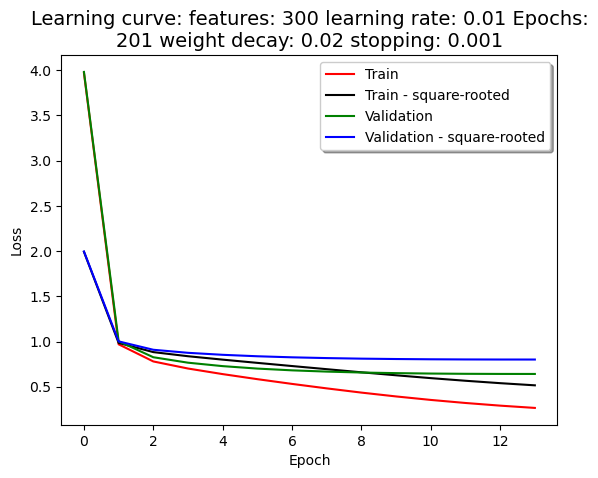

features: 300
learning rate: 0.01
Epochs: 201
weight decay: 0.2
stopping: 0.001



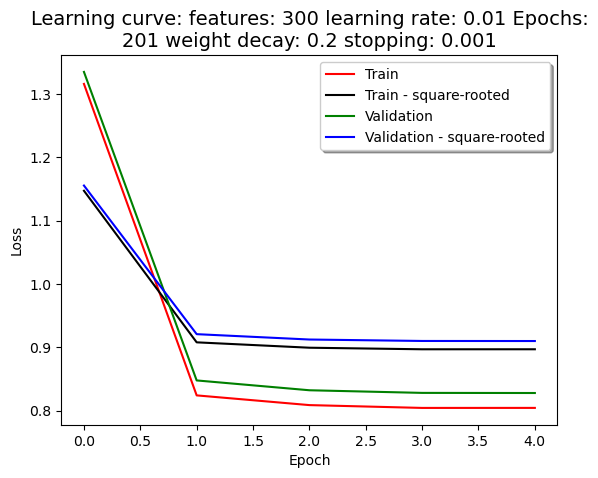

features: 300
learning rate: 0.01
Epochs: 201
weight decay: 2
stopping: 0.001



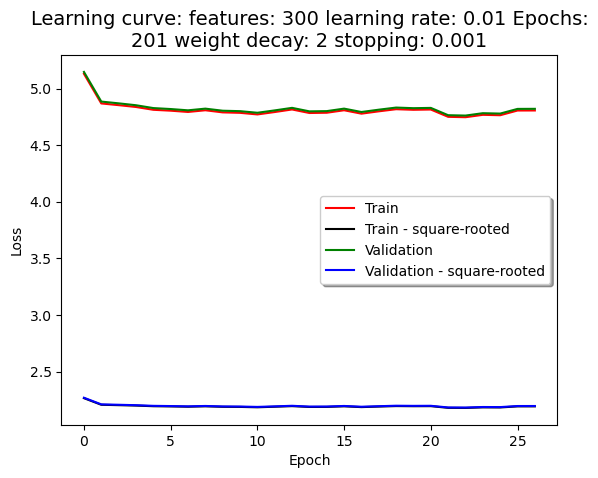

features: 300
learning rate: 0.001
Epochs: 201
weight decay: 0.02
stopping: 0.001



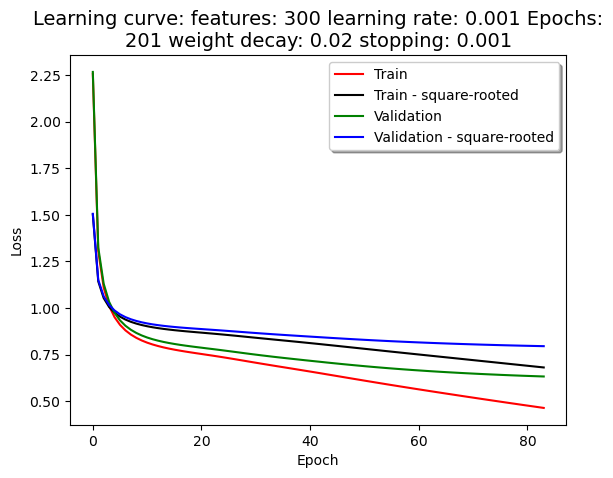

features: 300
learning rate: 0.001
Epochs: 201
weight decay: 0.2
stopping: 0.001



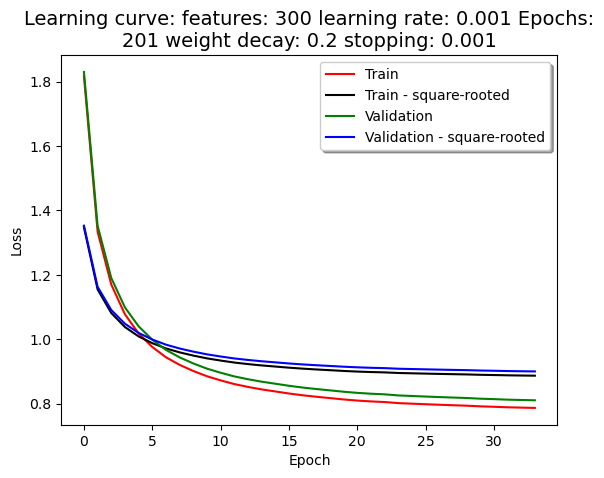

features: 300
learning rate: 0.001
Epochs: 201
weight decay: 2
stopping: 0.001



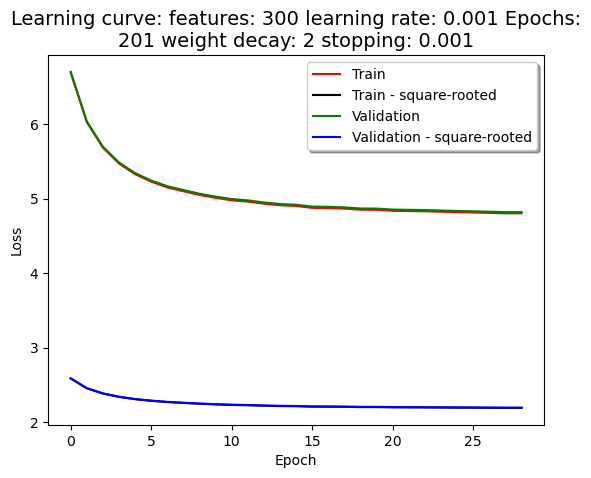

features: 300
learning rate: 0.0001
Epochs: 201
weight decay: 0.02
stopping: 0.001



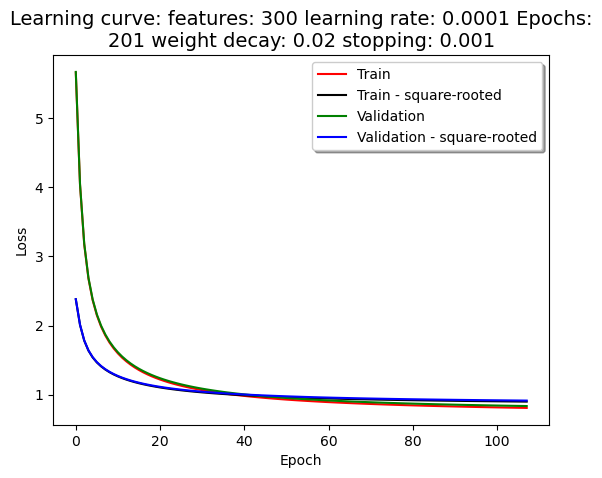

features: 300
learning rate: 0.0001
Epochs: 201
weight decay: 0.2
stopping: 0.001



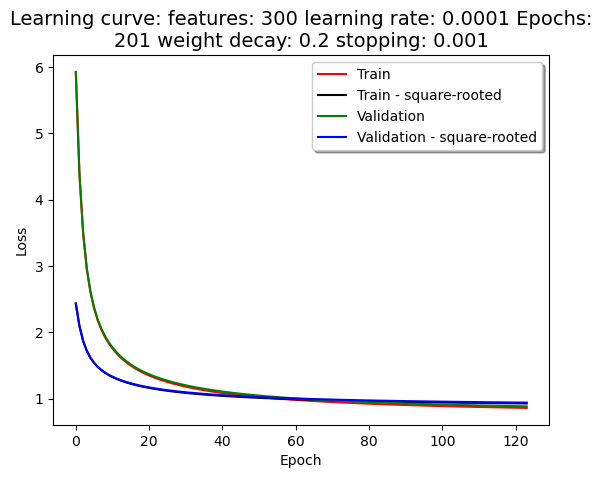

features: 300
learning rate: 0.0001
Epochs: 201
weight decay: 2
stopping: 0.001



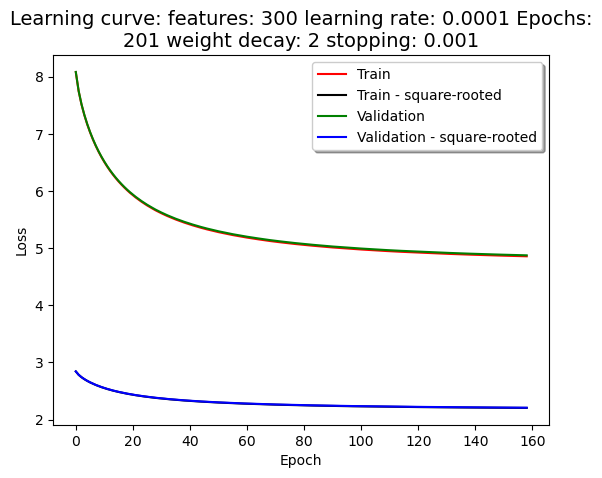

features: 3
learning rate: 0.01
Epochs: 301
weight decay: 0.02
stopping: 0.001



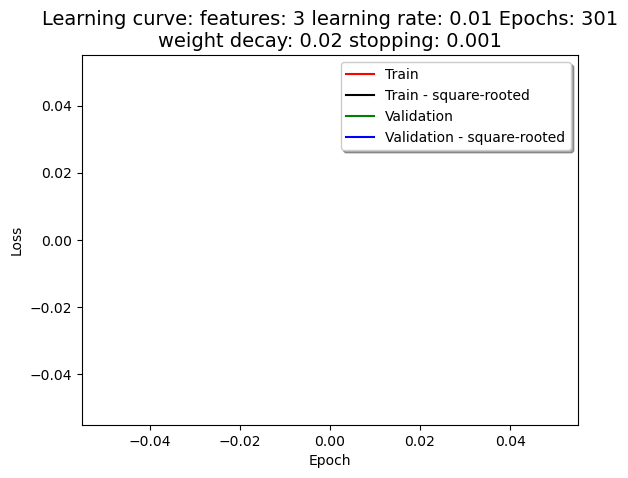

features: 3
learning rate: 0.01
Epochs: 301
weight decay: 0.2
stopping: 0.001



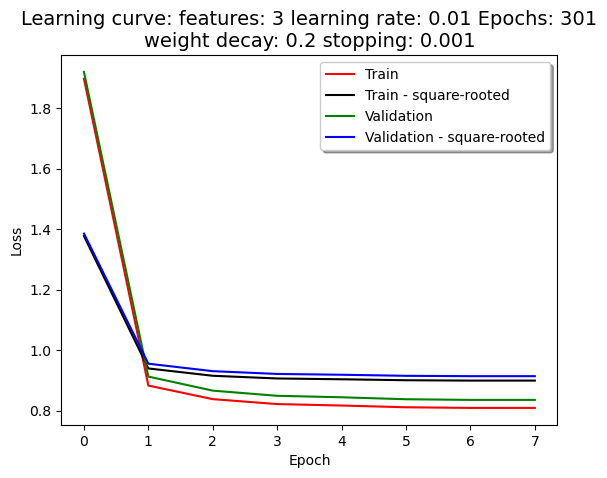

features: 3
learning rate: 0.01
Epochs: 301
weight decay: 2
stopping: 0.001



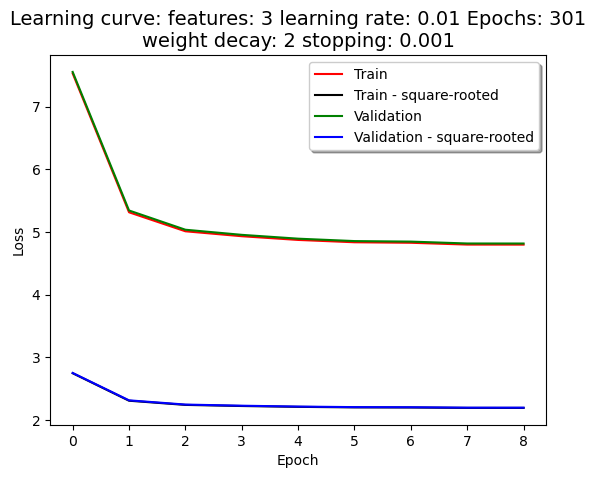

features: 3
learning rate: 0.001
Epochs: 301
weight decay: 0.02
stopping: 0.001



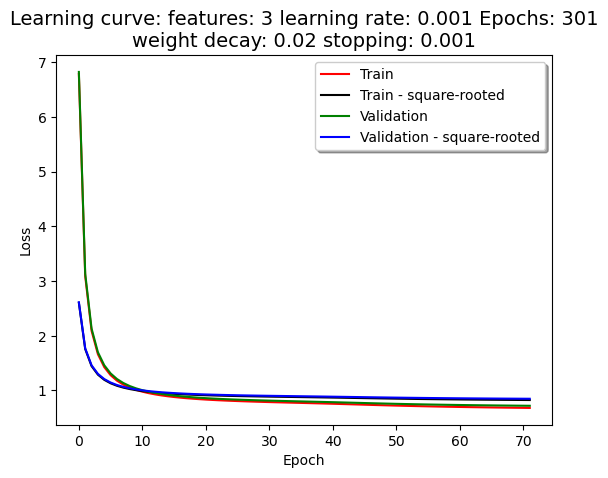

features: 3
learning rate: 0.001
Epochs: 301
weight decay: 0.2
stopping: 0.001



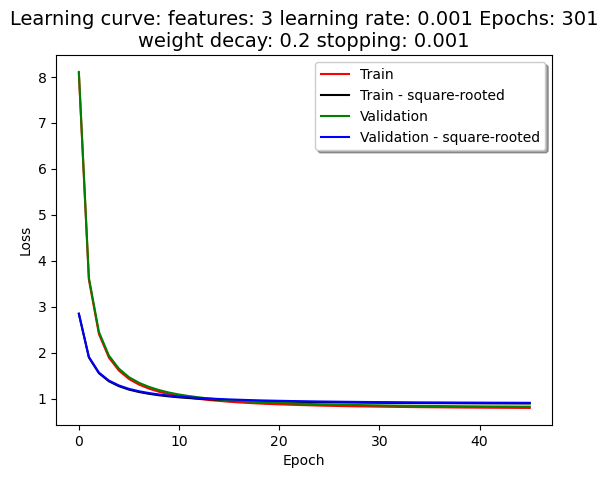

features: 3
learning rate: 0.001
Epochs: 301
weight decay: 2
stopping: 0.001



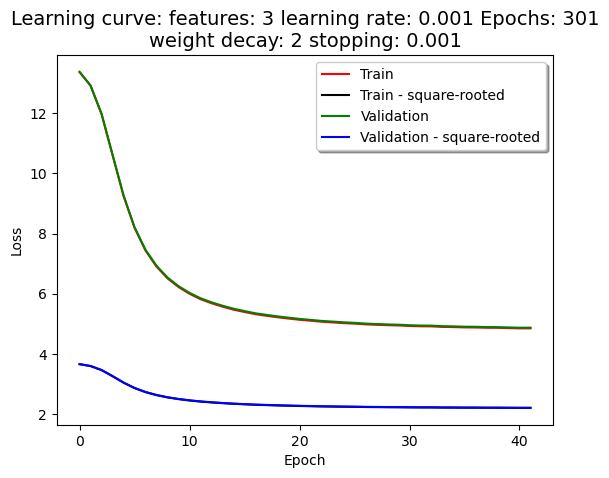

features: 3
learning rate: 0.0001
Epochs: 301
weight decay: 0.02
stopping: 0.001



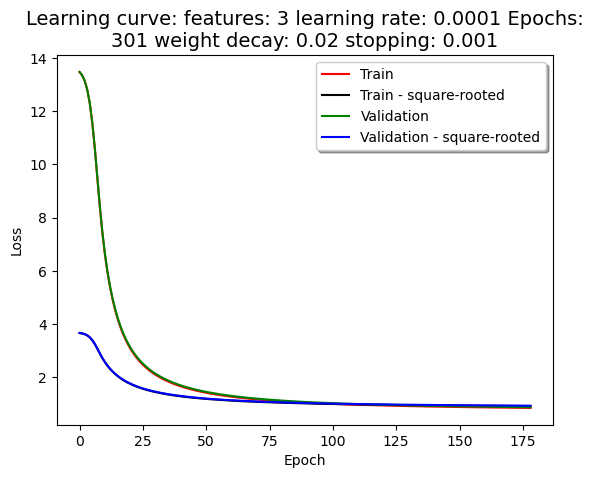

features: 3
learning rate: 0.0001
Epochs: 301
weight decay: 0.2
stopping: 0.001



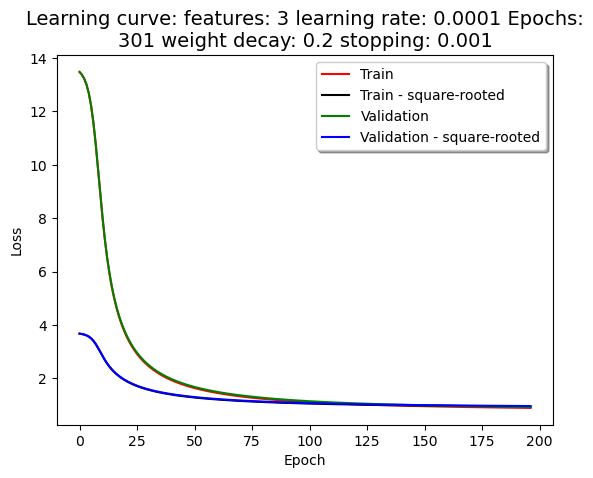

features: 3
learning rate: 0.0001
Epochs: 301
weight decay: 2
stopping: 0.001



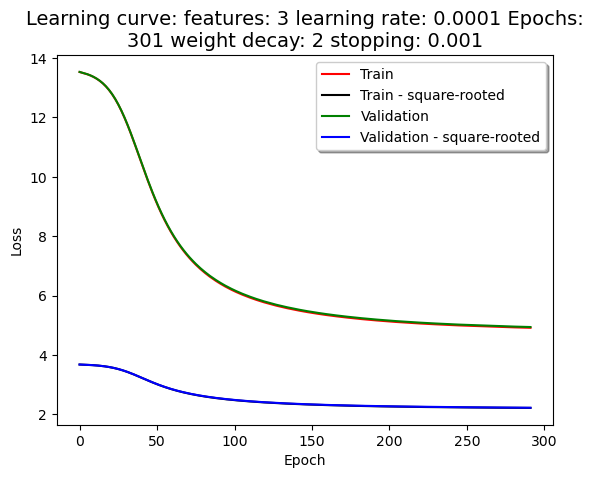

features: 30
learning rate: 0.01
Epochs: 301
weight decay: 0.02
stopping: 0.001



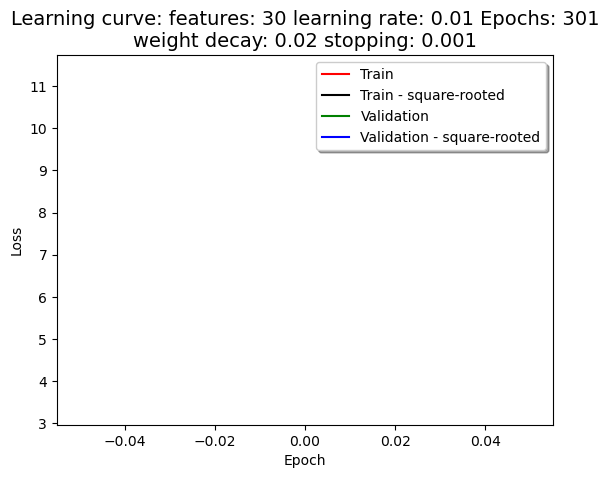

features: 30
learning rate: 0.01
Epochs: 301
weight decay: 0.2
stopping: 0.001



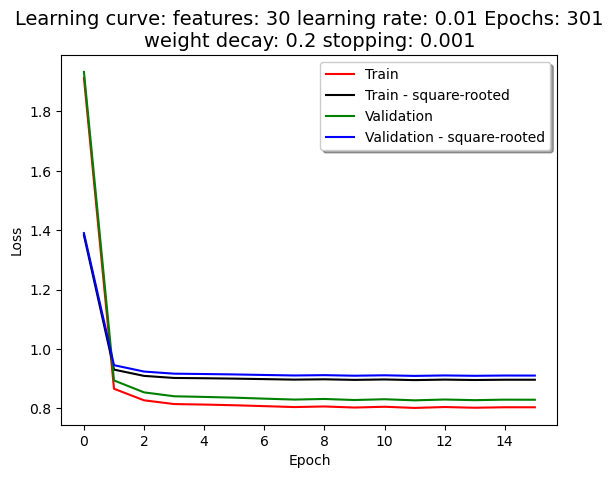

features: 30
learning rate: 0.01
Epochs: 301
weight decay: 2
stopping: 0.001



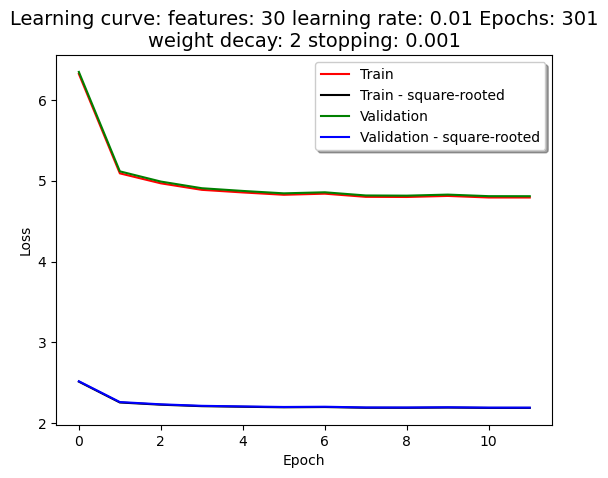

features: 30
learning rate: 0.001
Epochs: 301
weight decay: 0.02
stopping: 0.001



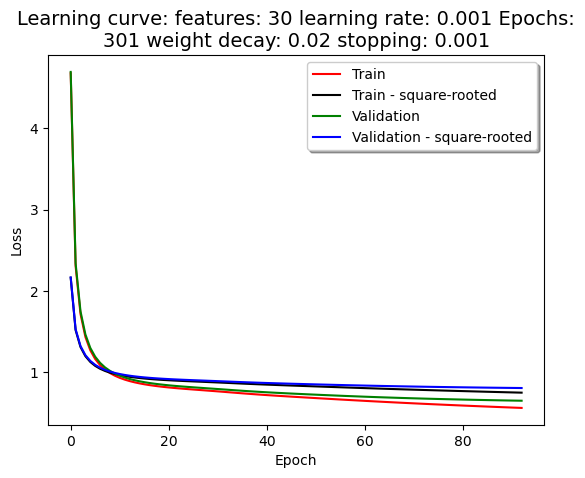

features: 30
learning rate: 0.001
Epochs: 301
weight decay: 0.2
stopping: 0.001



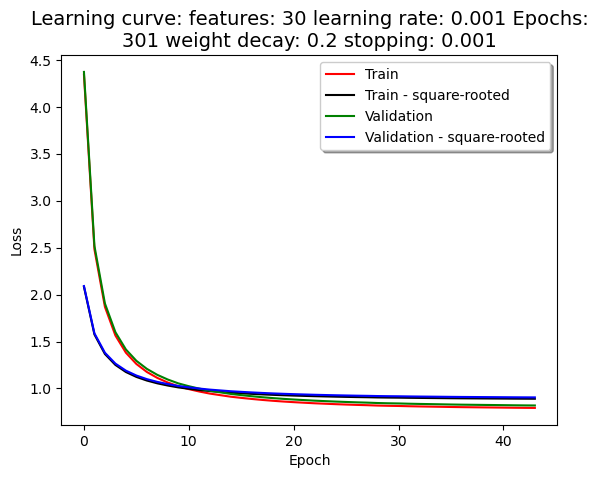

features: 30
learning rate: 0.001
Epochs: 301
weight decay: 2
stopping: 0.001



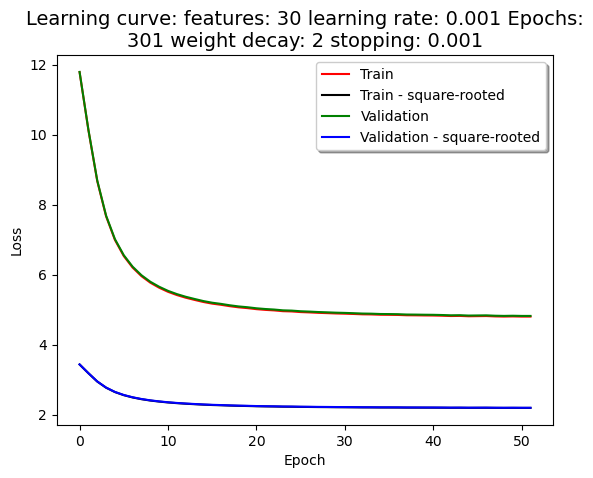

features: 30
learning rate: 0.0001
Epochs: 301
weight decay: 0.02
stopping: 0.001



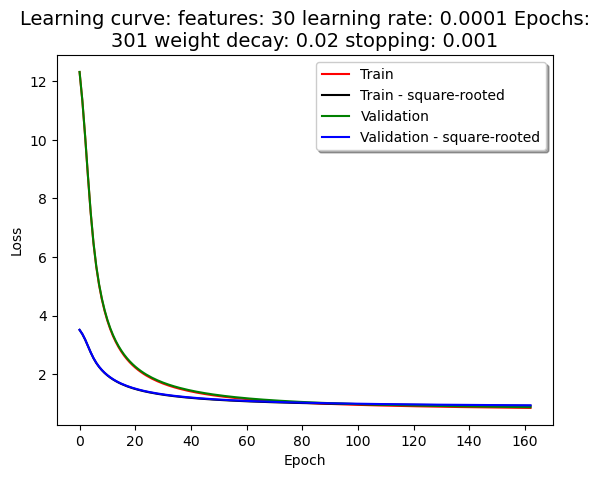

features: 30
learning rate: 0.0001
Epochs: 301
weight decay: 0.2
stopping: 0.001



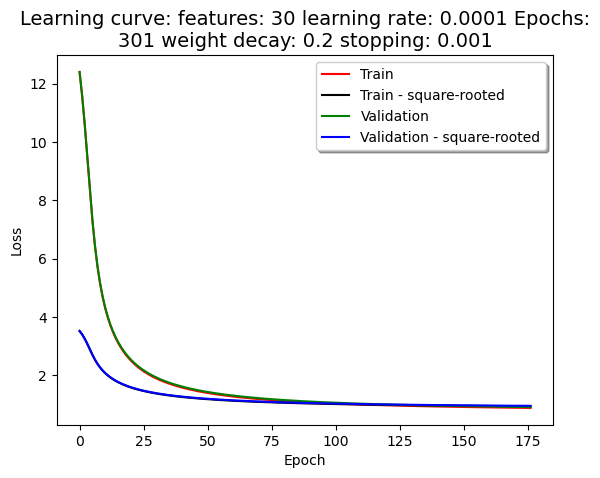

features: 30
learning rate: 0.0001
Epochs: 301
weight decay: 2
stopping: 0.001



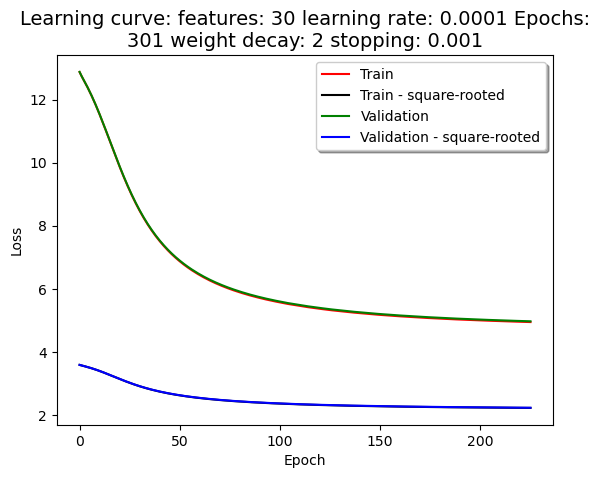

features: 150
learning rate: 0.01
Epochs: 301
weight decay: 0.02
stopping: 0.001



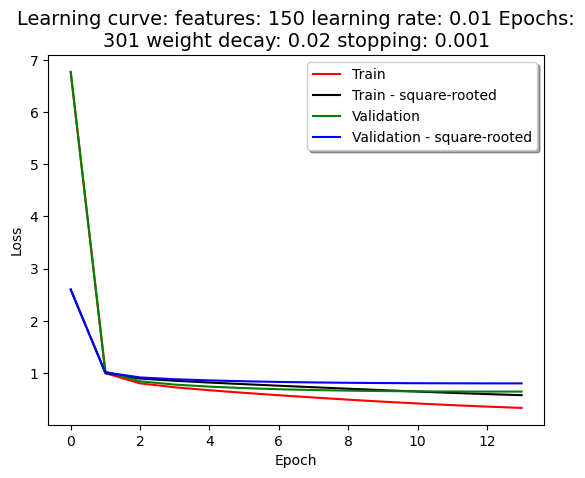

features: 150
learning rate: 0.01
Epochs: 301
weight decay: 0.2
stopping: 0.001



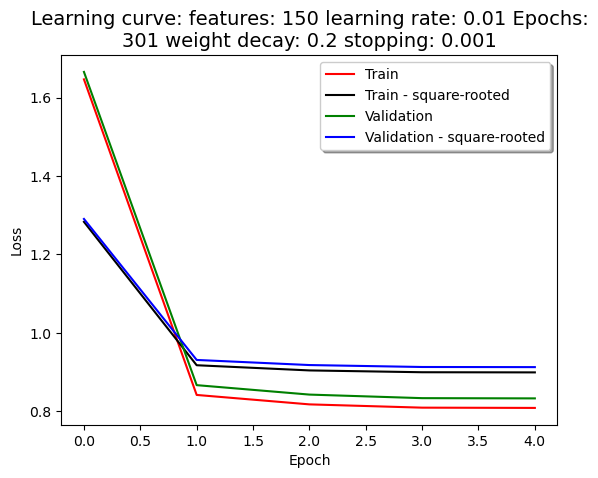

features: 150
learning rate: 0.01
Epochs: 301
weight decay: 2
stopping: 0.001



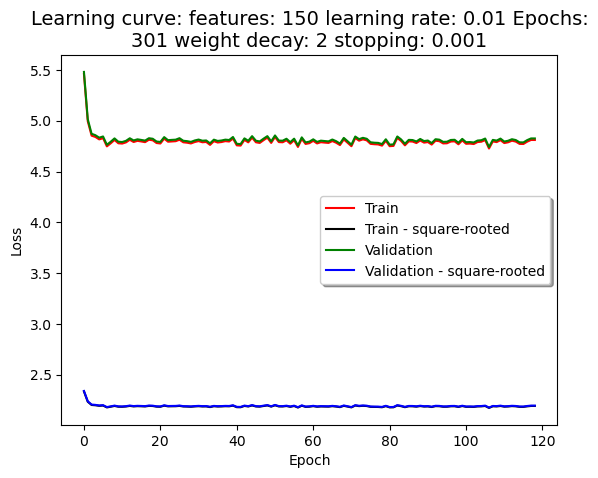

features: 150
learning rate: 0.001
Epochs: 301
weight decay: 0.02
stopping: 0.001



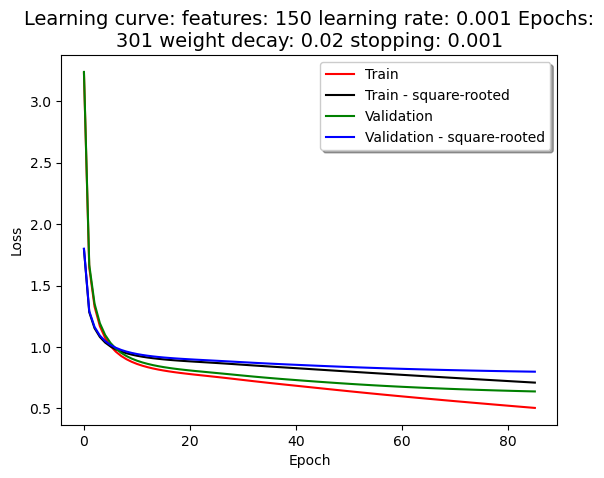

features: 150
learning rate: 0.001
Epochs: 301
weight decay: 0.2
stopping: 0.001



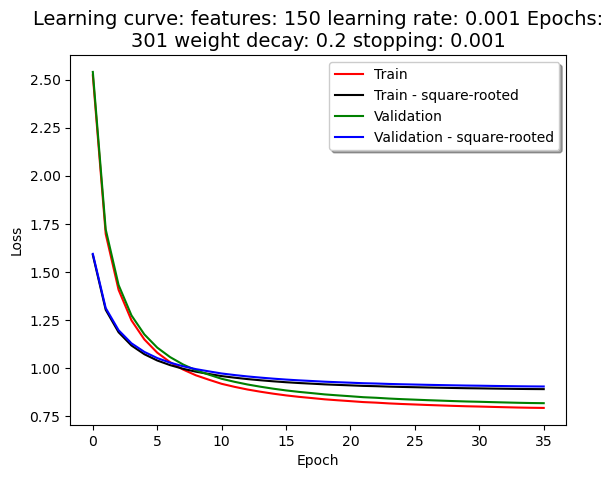

features: 150
learning rate: 0.001
Epochs: 301
weight decay: 2
stopping: 0.001



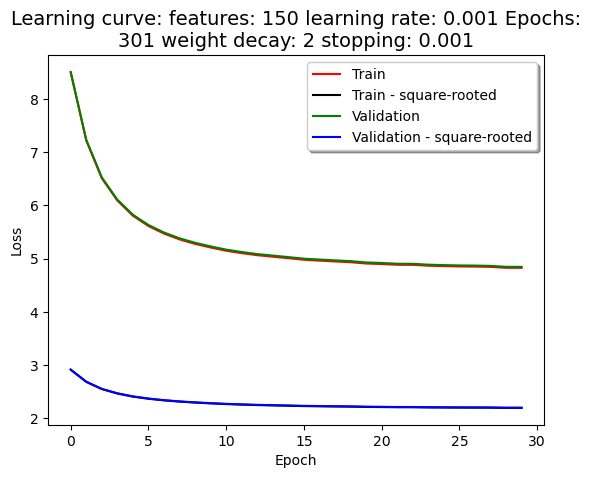

features: 150
learning rate: 0.0001
Epochs: 301
weight decay: 0.02
stopping: 0.001



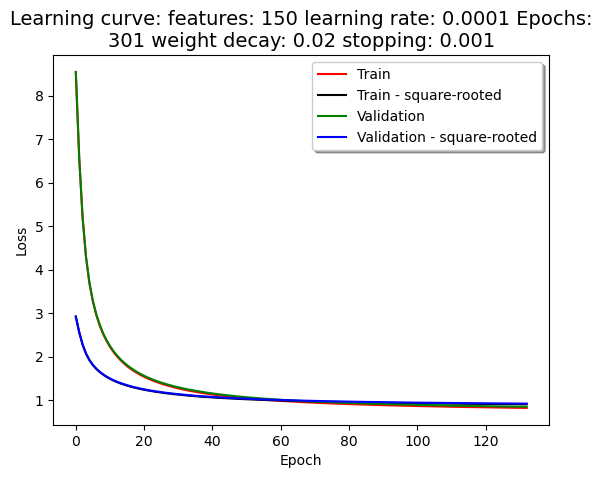

features: 150
learning rate: 0.0001
Epochs: 301
weight decay: 0.2
stopping: 0.001



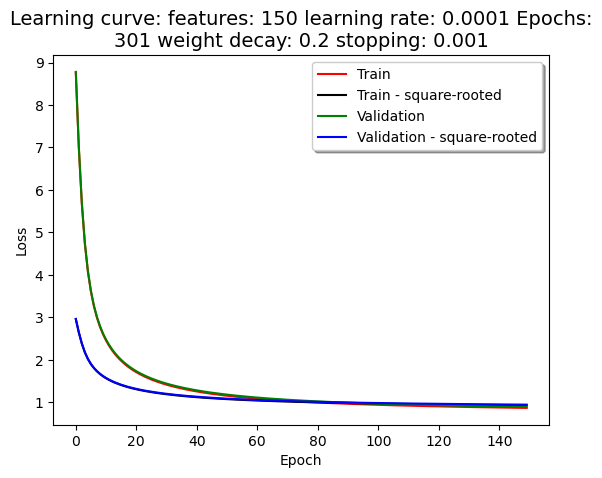

features: 150
learning rate: 0.0001
Epochs: 301
weight decay: 2
stopping: 0.001



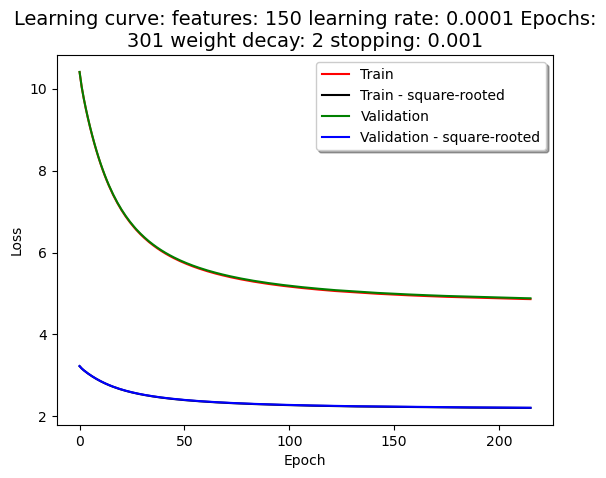

features: 300
learning rate: 0.01
Epochs: 301
weight decay: 0.02
stopping: 0.001



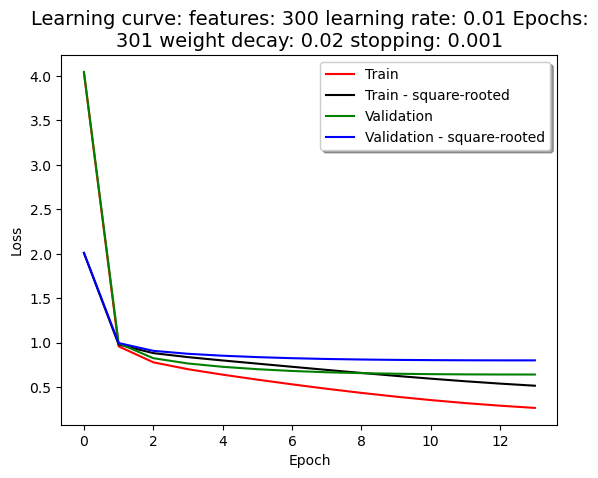

features: 300
learning rate: 0.01
Epochs: 301
weight decay: 0.2
stopping: 0.001



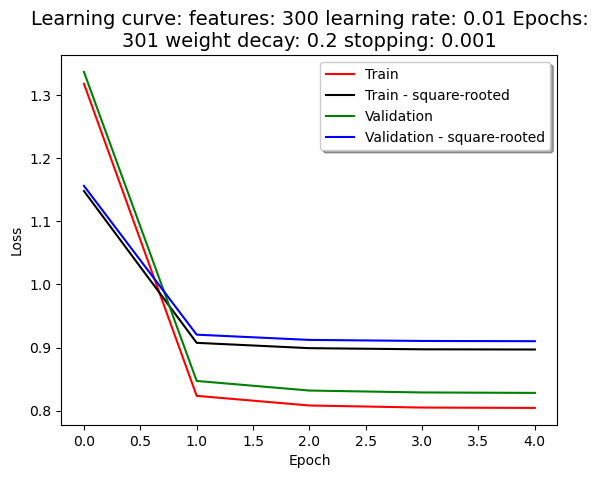

features: 300
learning rate: 0.01
Epochs: 301
weight decay: 2
stopping: 0.001



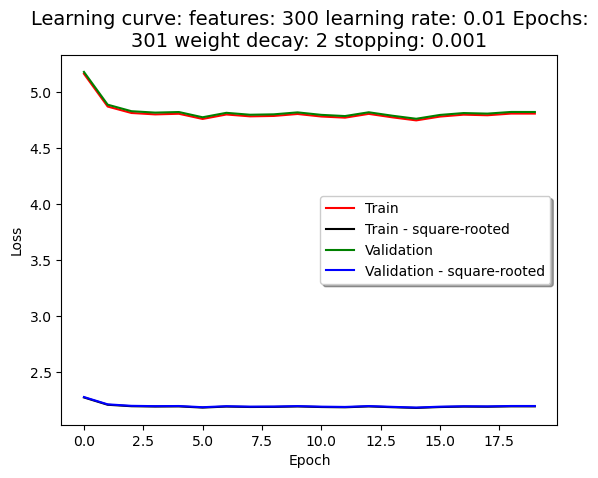

features: 300
learning rate: 0.001
Epochs: 301
weight decay: 0.02
stopping: 0.001



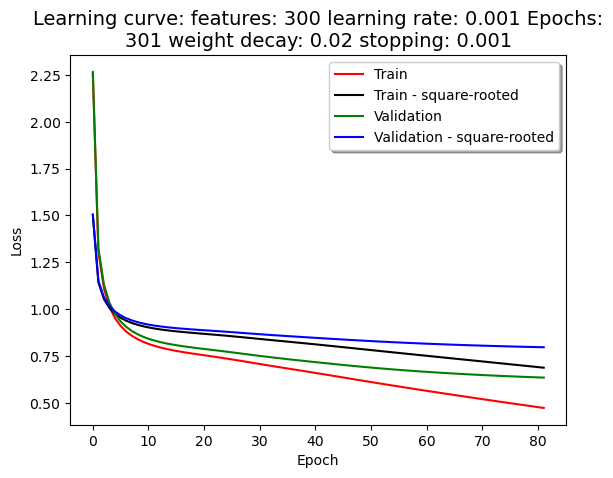

features: 300
learning rate: 0.001
Epochs: 301
weight decay: 0.2
stopping: 0.001



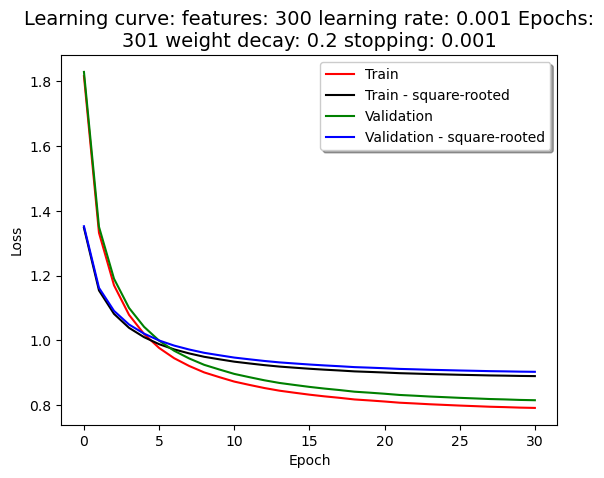

features: 300
learning rate: 0.001
Epochs: 301
weight decay: 2
stopping: 0.001



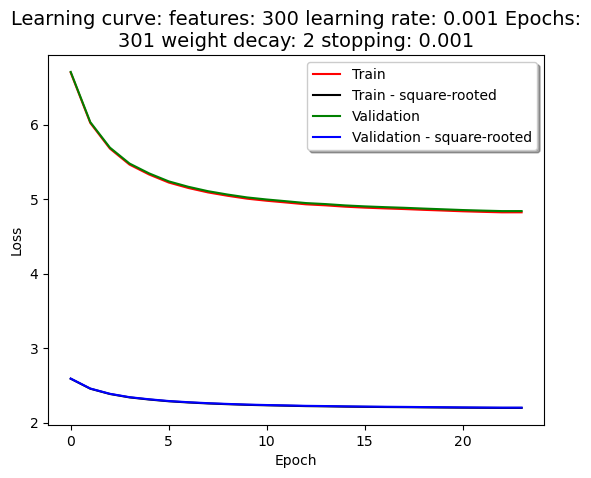

features: 300
learning rate: 0.0001
Epochs: 301
weight decay: 0.02
stopping: 0.001



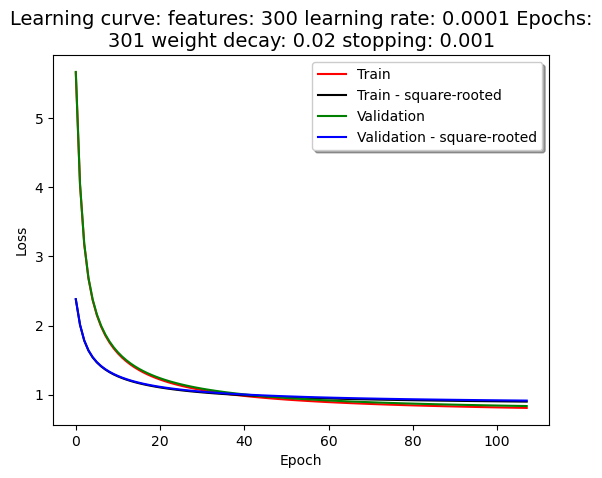

features: 300
learning rate: 0.0001
Epochs: 301
weight decay: 0.2
stopping: 0.001



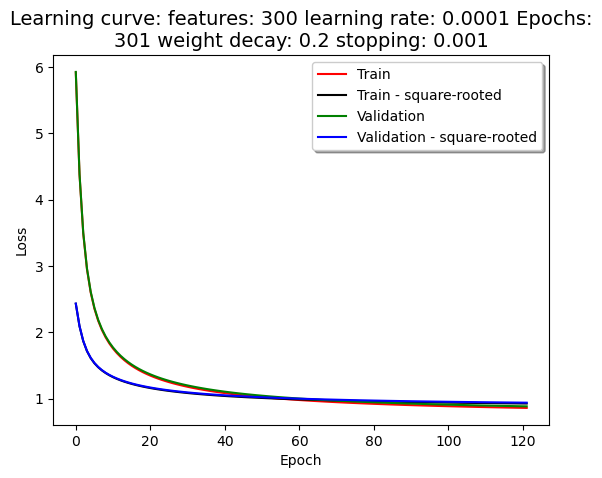

features: 300
learning rate: 0.0001
Epochs: 301
weight decay: 2
stopping: 0.001



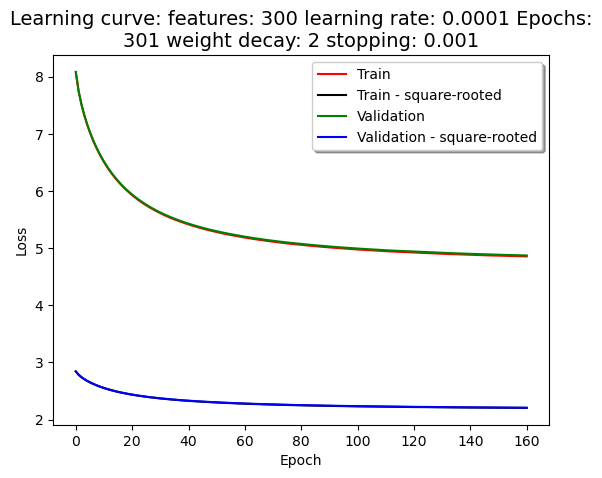

features: 3
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001



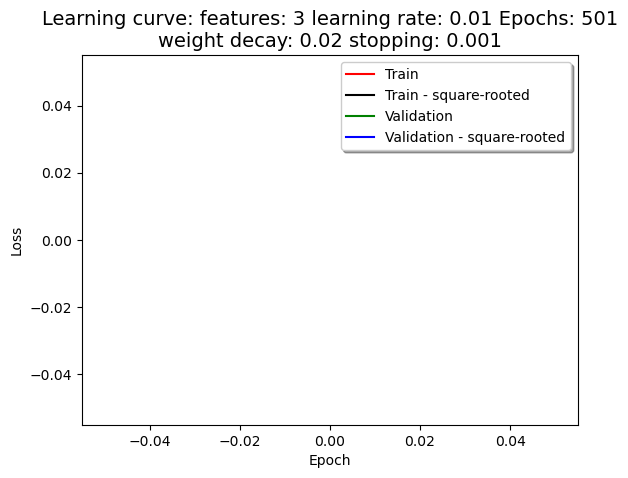

features: 3
learning rate: 0.01
Epochs: 501
weight decay: 0.2
stopping: 0.001



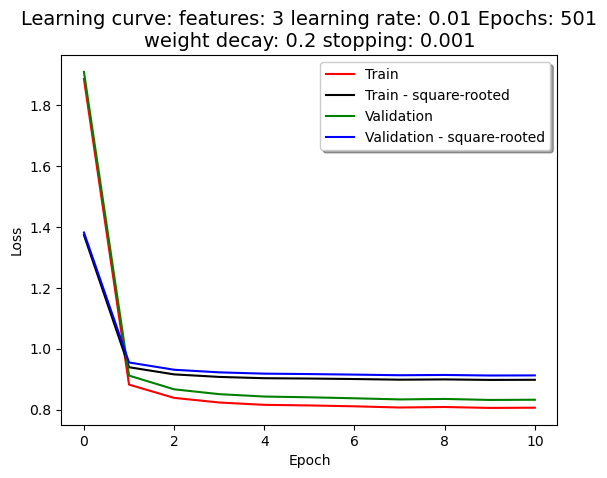

features: 3
learning rate: 0.01
Epochs: 501
weight decay: 2
stopping: 0.001



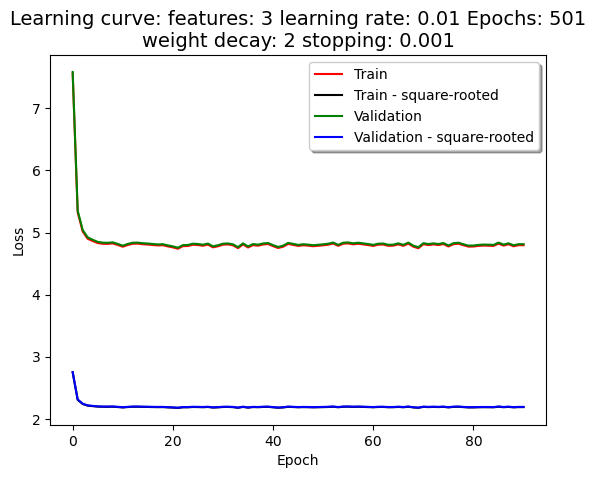

features: 3
learning rate: 0.001
Epochs: 501
weight decay: 0.02
stopping: 0.001



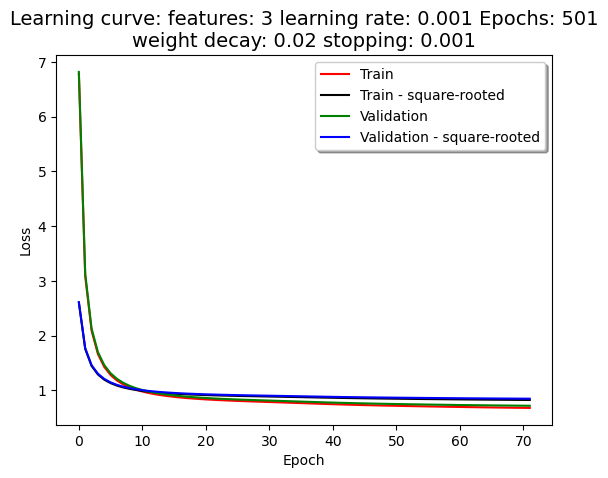

features: 3
learning rate: 0.001
Epochs: 501
weight decay: 0.2
stopping: 0.001



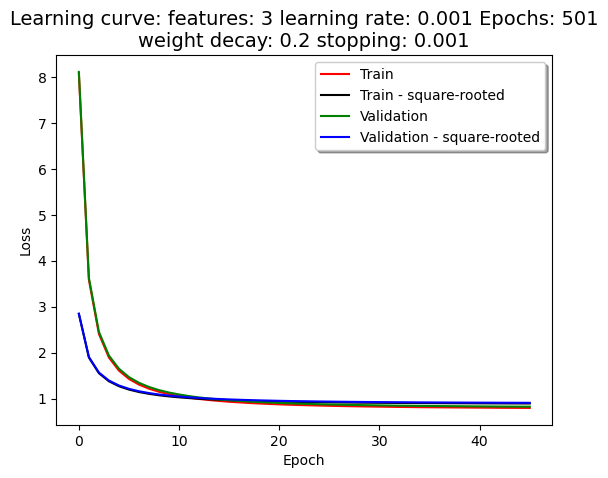

features: 3
learning rate: 0.001
Epochs: 501
weight decay: 2
stopping: 0.001



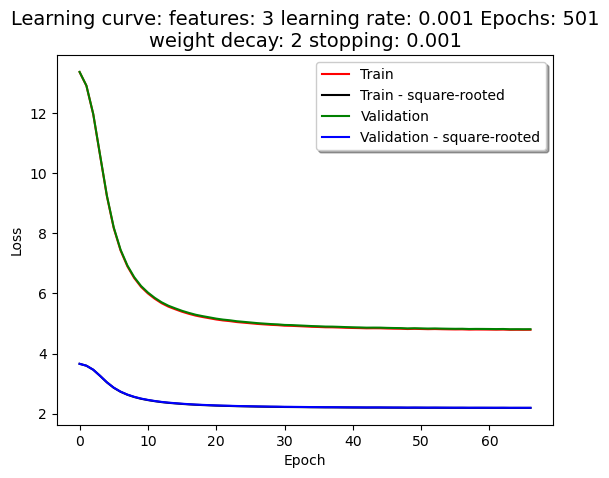

features: 3
learning rate: 0.0001
Epochs: 501
weight decay: 0.02
stopping: 0.001



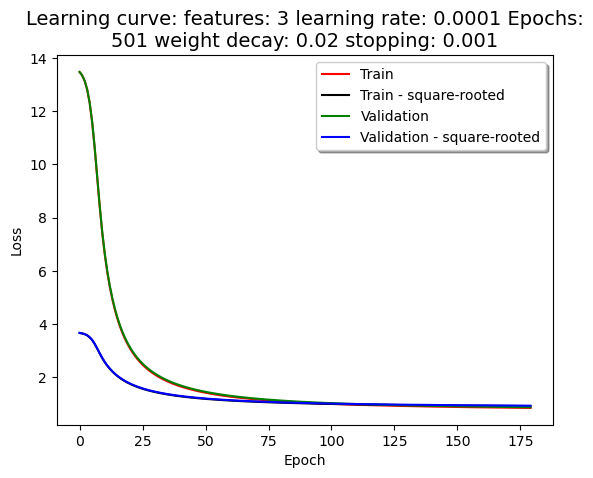

features: 3
learning rate: 0.0001
Epochs: 501
weight decay: 0.2
stopping: 0.001



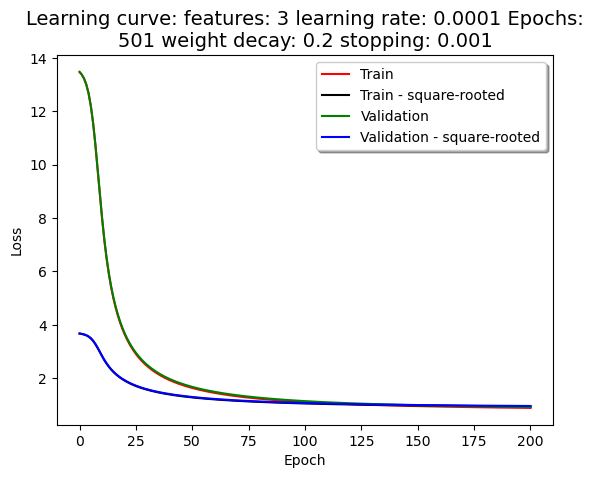

features: 3
learning rate: 0.0001
Epochs: 501
weight decay: 2
stopping: 0.001



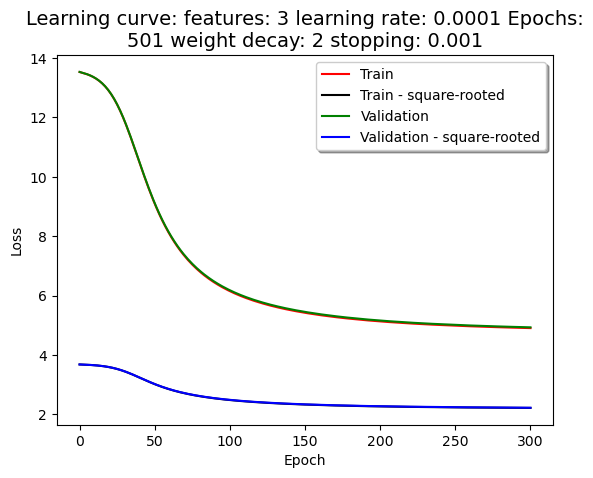

features: 30
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001



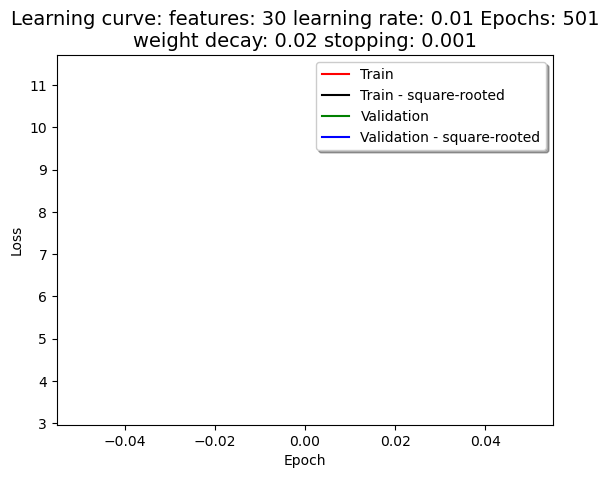

features: 30
learning rate: 0.01
Epochs: 501
weight decay: 0.2
stopping: 0.001



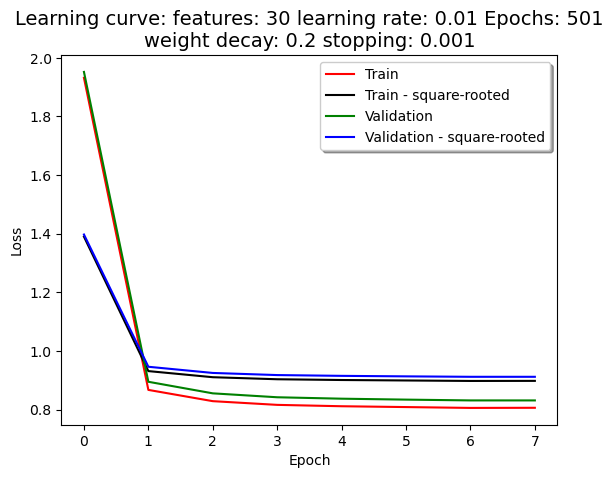

features: 30
learning rate: 0.01
Epochs: 501
weight decay: 2
stopping: 0.001



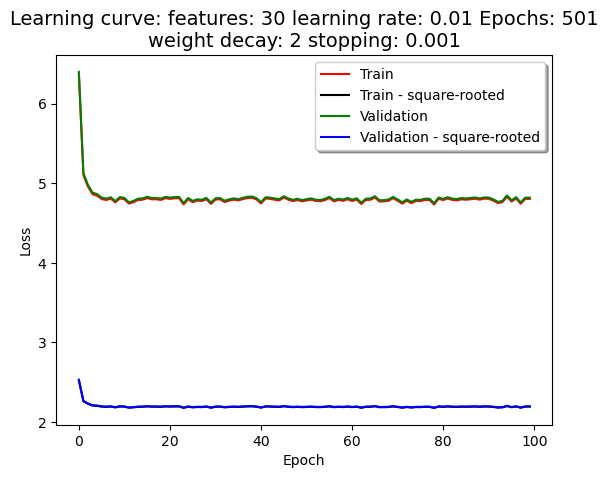

features: 30
learning rate: 0.001
Epochs: 501
weight decay: 0.02
stopping: 0.001



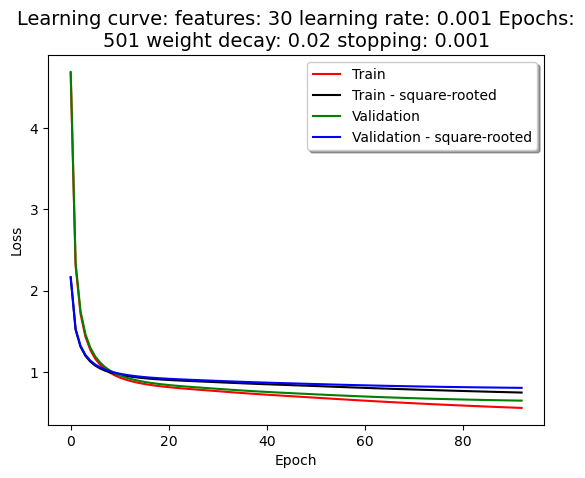

features: 30
learning rate: 0.001
Epochs: 501
weight decay: 0.2
stopping: 0.001



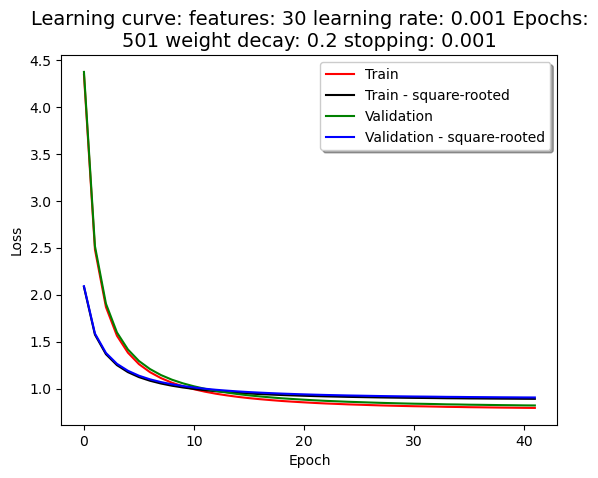

features: 30
learning rate: 0.001
Epochs: 501
weight decay: 2
stopping: 0.001



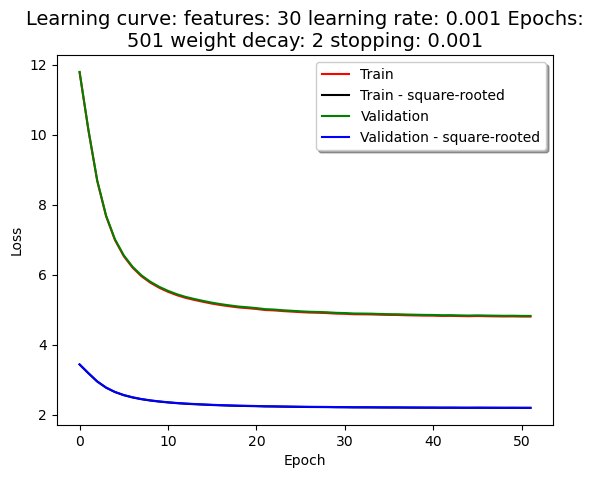

features: 30
learning rate: 0.0001
Epochs: 501
weight decay: 0.02
stopping: 0.001



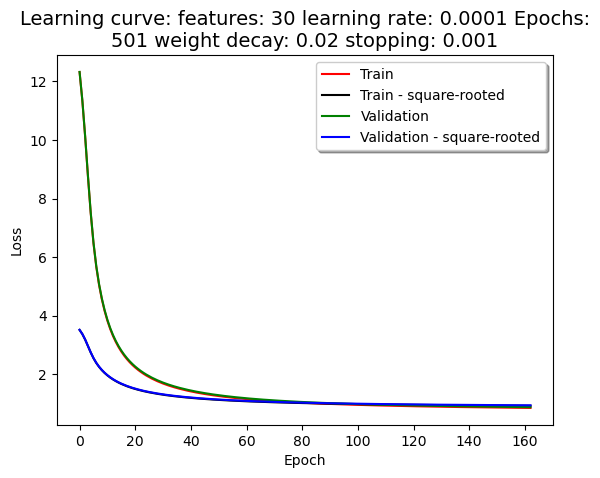

features: 30
learning rate: 0.0001
Epochs: 501
weight decay: 0.2
stopping: 0.001



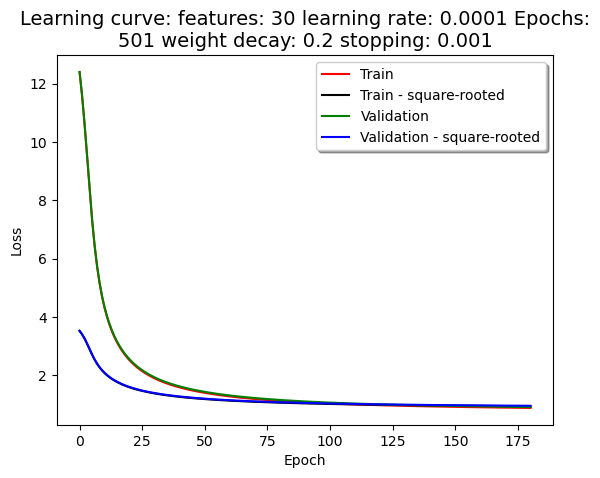

features: 30
learning rate: 0.0001
Epochs: 501
weight decay: 2
stopping: 0.001



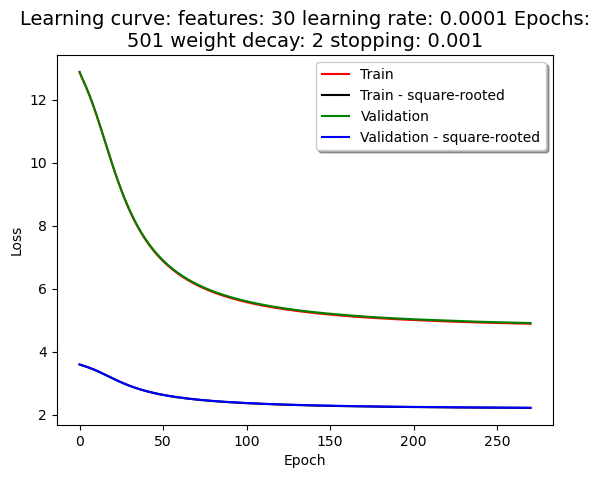

features: 150
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001



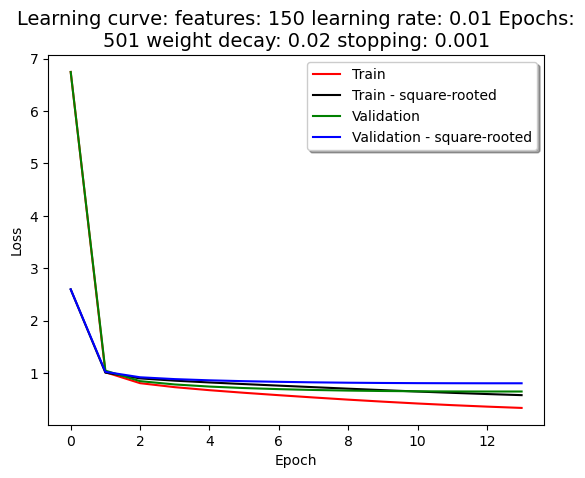

features: 150
learning rate: 0.01
Epochs: 501
weight decay: 0.2
stopping: 0.001



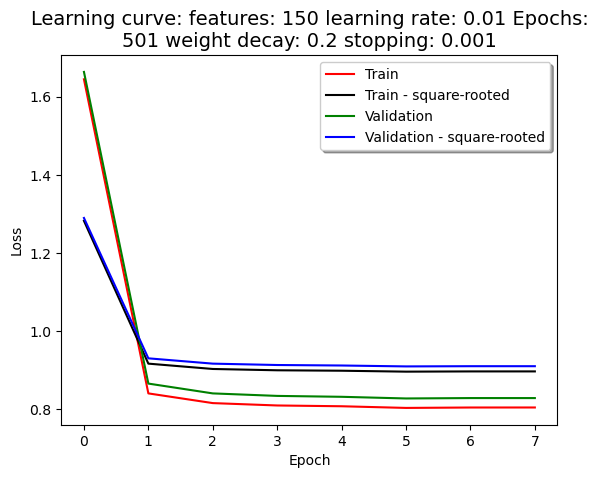

features: 150
learning rate: 0.01
Epochs: 501
weight decay: 2
stopping: 0.001



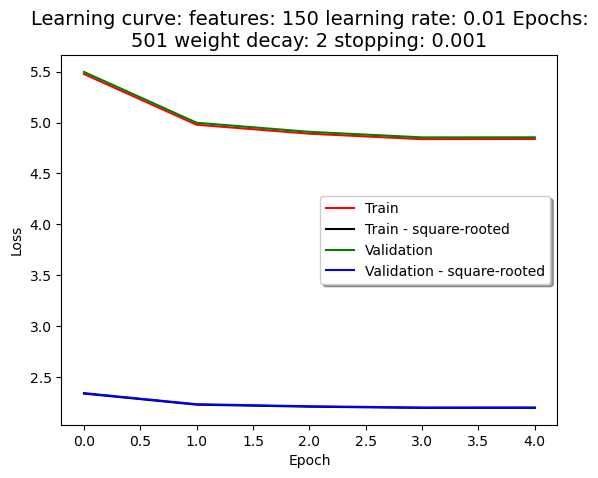

features: 150
learning rate: 0.001
Epochs: 501
weight decay: 0.02
stopping: 0.001



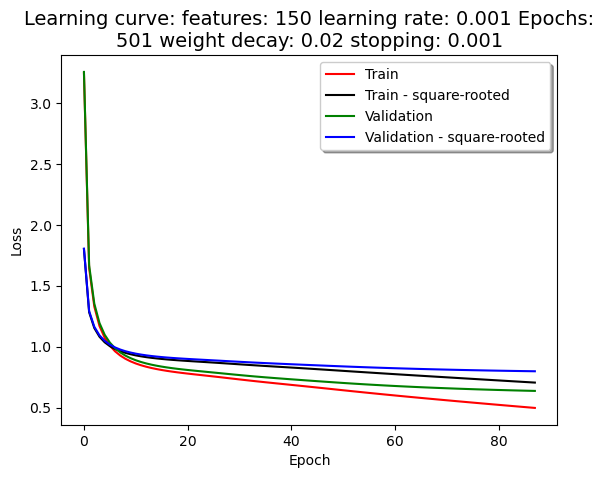

features: 150
learning rate: 0.001
Epochs: 501
weight decay: 0.2
stopping: 0.001



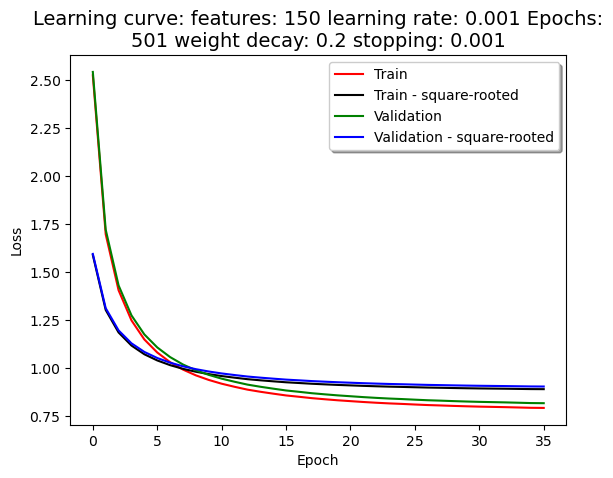

features: 150
learning rate: 0.001
Epochs: 501
weight decay: 2
stopping: 0.001



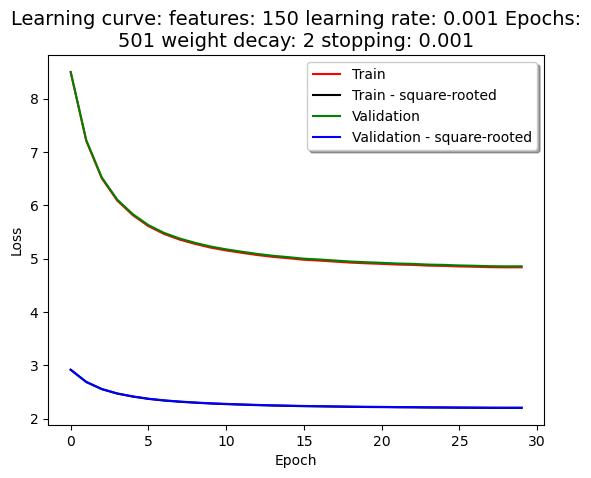

features: 150
learning rate: 0.0001
Epochs: 501
weight decay: 0.02
stopping: 0.001



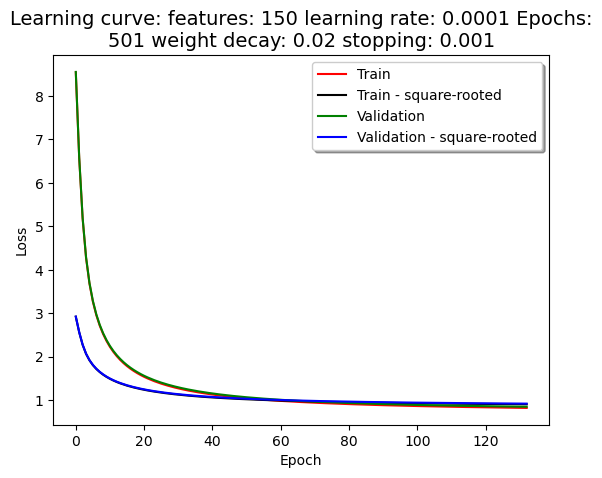

features: 150
learning rate: 0.0001
Epochs: 501
weight decay: 0.2
stopping: 0.001



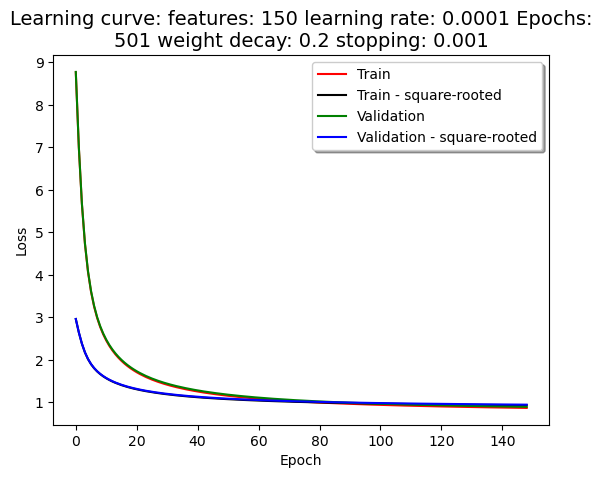

features: 150
learning rate: 0.0001
Epochs: 501
weight decay: 2
stopping: 0.001



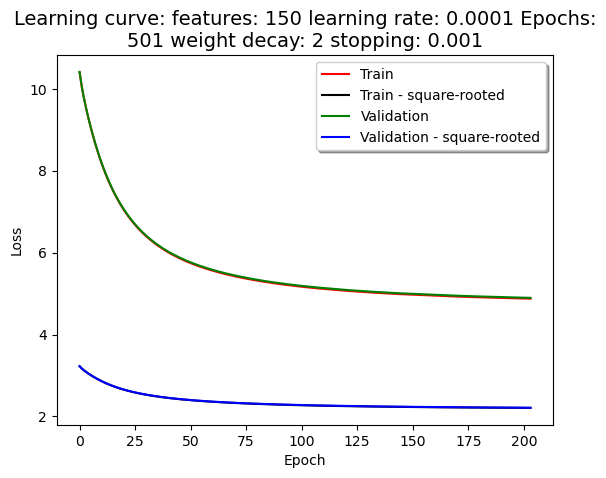

features: 300
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001



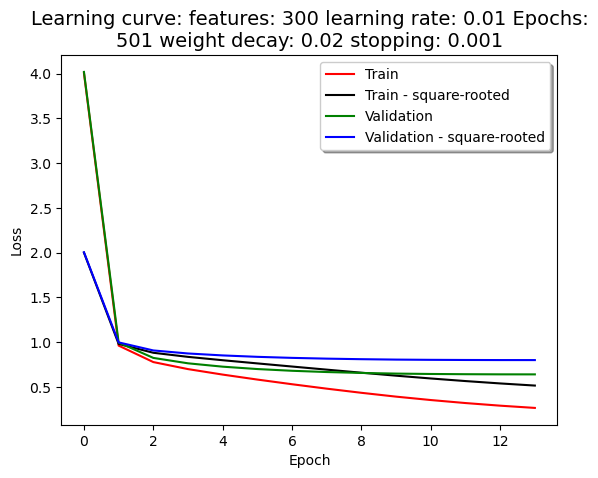

features: 300
learning rate: 0.01
Epochs: 501
weight decay: 0.2
stopping: 0.001



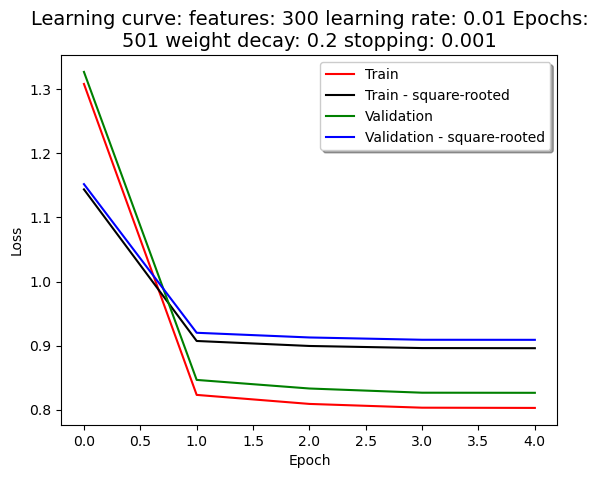

features: 300
learning rate: 0.01
Epochs: 501
weight decay: 2
stopping: 0.001



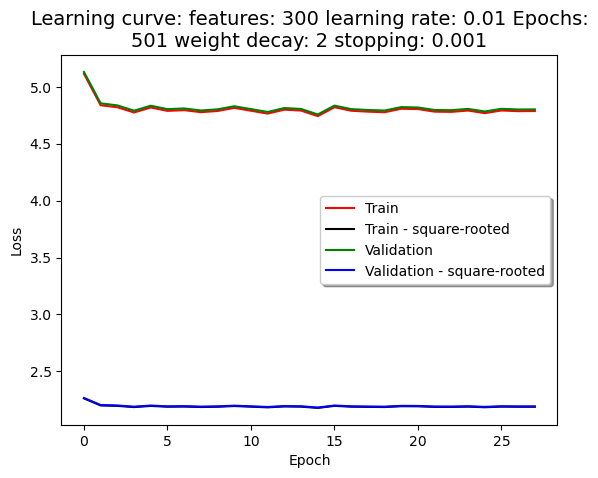

features: 300
learning rate: 0.001
Epochs: 501
weight decay: 0.02
stopping: 0.001



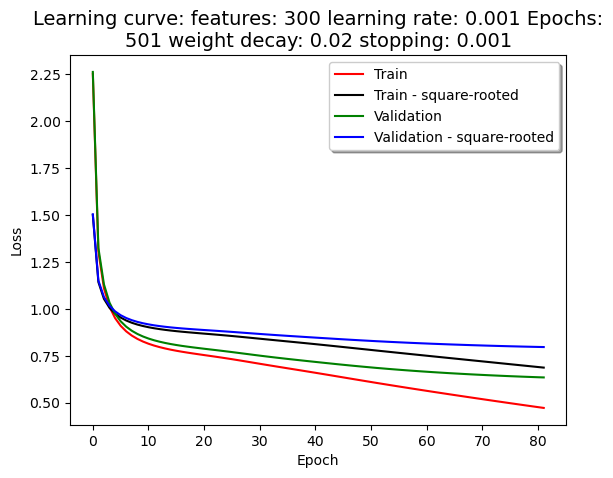

features: 300
learning rate: 0.001
Epochs: 501
weight decay: 0.2
stopping: 0.001



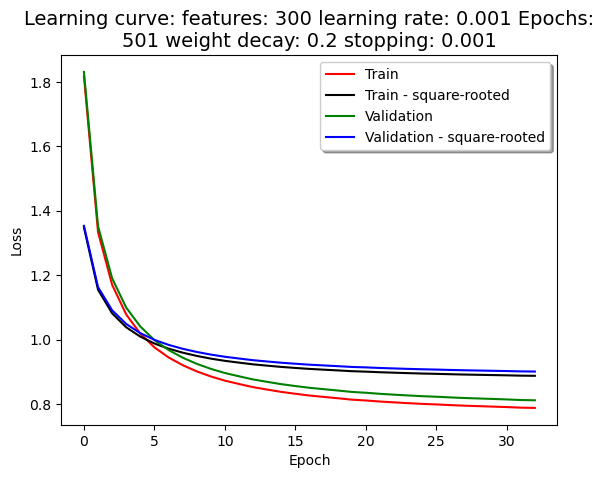

features: 300
learning rate: 0.001
Epochs: 501
weight decay: 2
stopping: 0.001



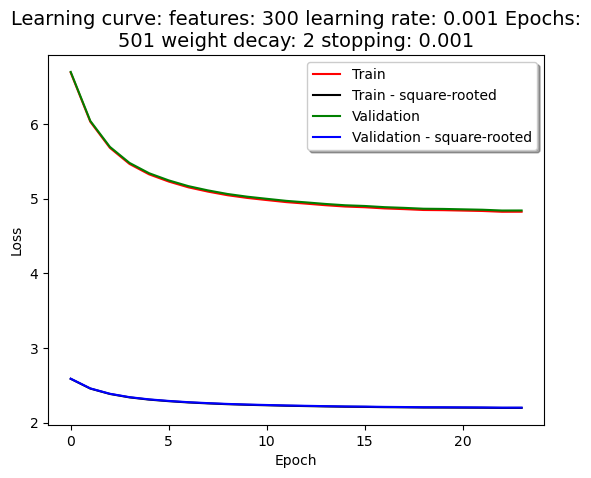

features: 300
learning rate: 0.0001
Epochs: 501
weight decay: 0.02
stopping: 0.001



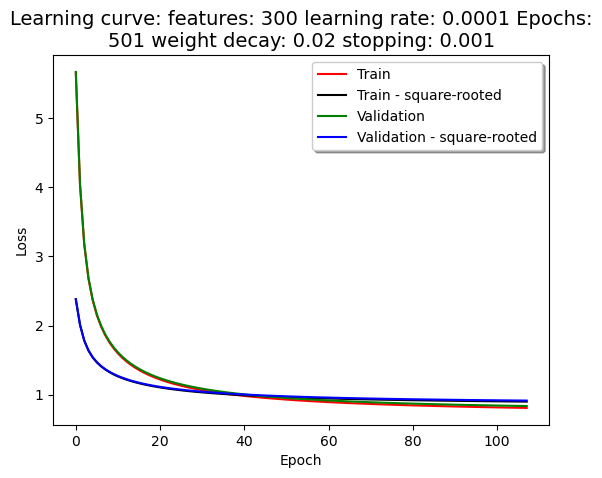

features: 300
learning rate: 0.0001
Epochs: 501
weight decay: 0.2
stopping: 0.001



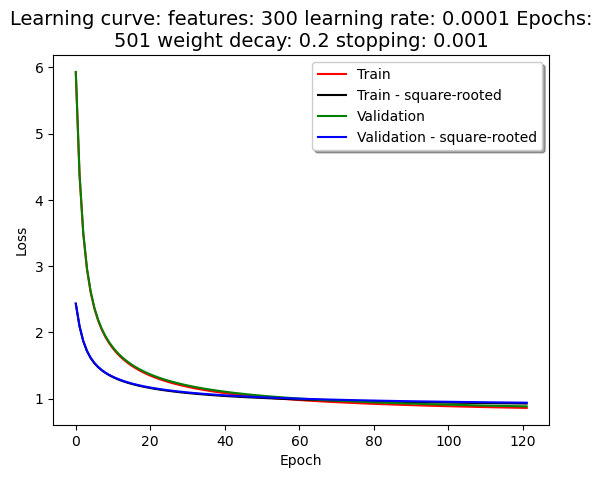

features: 300
learning rate: 0.0001
Epochs: 501
weight decay: 2
stopping: 0.001



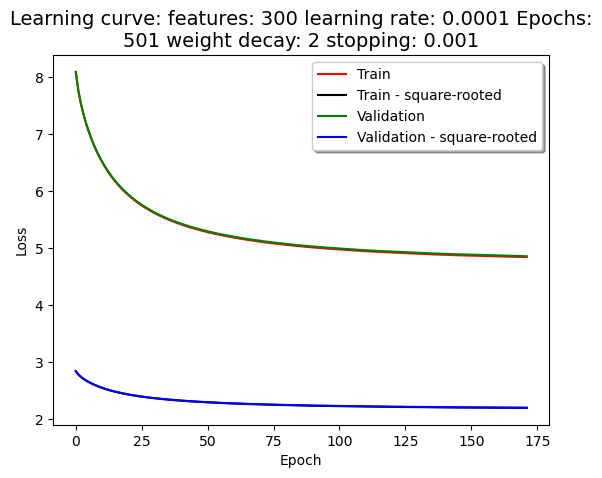

In [19]:
from textwrap import wrap
for epochs in PARAM['epochs']:
    for features in PARAM['features']:
        for lr in PARAM['lr']:
            for weight_decay in PARAM['weight_decay']:
                if os.path.isfile(f'./model_movielens/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
#                     with open(f'./model_movielens/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'rb') as inp:
#                         svd = pickle.load(inp)
#                         print(f'\nfeatures: {svd.features}\nlearning rate: {svd.lr}\nEpochs: {svd.epochs}\nweight decay: {svd.weight_decay}\nstopping: 0.001\n')
#                         inp.close()
                    with open(f'./model_movielens/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'rb') as inp:
                        print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
                        k=0
                        result = pickle.load(inp)
                        plt.plot(list(range(len(result[0])))[-k:], result[0][-k:], 'r', label="Train")
                        plt.plot(list(range(len(result[0])))[-k:], np.sqrt(result[0][-k:]), '#000', label="Train - square-rooted")
                        plt.plot(list(range(len(result[1])))[-k:], result[1][-k:], 'g', label="Validation")
                        plt.plot(list(range(len(result[1])))[-k:], np.sqrt(result[1][-k:]), 'b', label="Validation - square-rooted")
                        title = f"Learning curve: features: {features} learning rate: {lr} Epochs: {epochs} weight decay: {weight_decay} stopping: {PARAM['stopping']}"
                        plt.title('\n'.join(wrap(title,60)), fontsize=14)
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        leg = plt.legend(loc='best', shadow=True, fancybox=True)
                        plt.savefig(f"./model_movielens/funk/plt_images/{features}_{lr}_{epochs}_{weight_decay}_0.001.png")
                        plt.show()
                        inp.close()

In [23]:
minTrainLoss = float('+inf')
minValidLoss = float('+inf')
minTestLoss = float('+inf')

bestTrainLossModel = ''
bestValidLossModel = ''
bestTestLossModel = ''

for epochs in PARAM['epochs']:
    for features in PARAM['features']:
        for lr in PARAM['lr']:
            for weight_decay in PARAM['weight_decay']:
                if os.path.isfile(f'./model_movielens/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
#                     with open(f'./model_movielens/funk/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'rb') as inp:
#                         svd = pickle.load(inp)
#                         print(f'\nfeatures: {svd.features}\nlearning rate: {svd.lr}\nEpochs: {svd.epochs}\nweight decay: {svd.weight_decay}\nstopping: 0.001\n')
#                         inp.close()
                    with open(f'./model_movielens/funk/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'rb') as inp:
                        # print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
                        # k=0
                        result = pickle.load(inp)
                        lastTrainLoss = result[0][-1]
                        lastValidLoss = result[1][-1]
                        lastTestLoss = result[2]
                        if lastTrainLoss < minTrainLoss:
                            minTrainLoss = lastTrainLoss
                            bestTrainLossModel = f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n'
                            bestTrainLossModel += f'lastTrainLoss: {lastTrainLoss}\tlastValidLoss: {lastValidLoss}\tlastTestLoss: {lastTestLoss}\n'
                        if lastValidLoss < minValidLoss:
                            minValidLoss = lastValidLoss
                            bestValidLossModel = f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n'
                            bestValidLossModel += f'lastTrainLoss: {lastTrainLoss}\tlastValidLoss: {lastValidLoss}\tlastTestLoss: {lastTestLoss}\n'

                        if lastTestLoss < minTestLoss:
                            minTestLoss = lastTestLoss
                            bestTestLossModel = f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n'
                            bestTestLossModel += f'lastTrainLoss: {lastTrainLoss}\tlastValidLoss: {lastValidLoss}\tlastTestLoss: {lastTestLoss}\n'

                        inp.close()

print(f'bestTrainLossModel\n{bestTrainLossModel}')
print(f'minTrainLoss: {minTrainLoss}')

print(f'bestValidLossModel\n{bestValidLossModel}')
print(f'minValidLoss: {minValidLoss}')

print(f'bestValidLossModel\n{bestTestLossModel}')
print(f'minTestLoss: {minTestLoss}')

bestTrainLossModel
features: 300
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001
lastTrainLoss: 0.2660630033178624	lastValidLoss: 0.6408790903172763	lastTestLoss: 0.6421199704153656

minTrainLoss: 0.2660630033178624
bestValidLossModel
features: 300
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001
lastTrainLoss: 0.46429075473687037	lastValidLoss: 0.6326786205887001	lastTestLoss: 0.6335584201767969

minValidLoss: 0.6326786205887001
bestValidLossModel
features: 300
learning rate: 0.001
Epochs: 101
weight decay: 0.02
stopping: 0.001
lastTrainLoss: 0.46429075473687037	lastValidLoss: 0.6326786205887001	lastTestLoss: 0.6335584201767969

minTestLoss: 0.6335584201767969
